##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [predicting fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) — we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the train data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.4.0


In [4]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

      8192/2816407858 [..............................] - ETA: 22s

     16384/2816407858 [..............................] - ETA: 6:22:50

     49152/2816407858 [..............................] - ETA: 4:17:56

     90112/2816407858 [..............................] - ETA: 3:30:48

    122880/2816407858 [..............................] - ETA: 3:30:41

    221184/2816407858 [..............................] - ETA: 2:24:58

    417792/2816407858 [..............................] - ETA: 1:31:10

    770048/2816407858 [..............................] - ETA: 57:16  

   1482752/2816407858 [..............................] - ETA: 33:48

   2908160/2816407858 [..............................] - ETA: 19:18

   5726208/2816407858 [..............................] - ETA: 10:15

   5758976/2816407858 [..............................] - ETA: 10:46

   8863744/2816407858 [..............................] - ETA: 7:40 

  12009472/2816407858 [..............................] - ETA: 6:09

  14966784/2816407858 [..............................] - ETA: 5:20

  18104320/2816407858 [..............................] - ETA: 4:44

  21151744/2816407858 [..............................] - ETA: 4:20

  24297472/2816407858 [..............................] - ETA: 4:01

  27394048/2816407858 [..............................] - ETA: 3:47

  30531584/2816407858 [..............................] - ETA: 3:35

  33611776/2816407858 [..............................] - ETA: 3:26

  36691968/2816407858 [..............................] - ETA: 3:18

  39788544/2816407858 [..............................] - ETA: 3:08

  39837696/2816407858 [..............................] - ETA: 3:11

  42909696/2816407858 [..............................] - ETA: 3:02

  42934272/2816407858 [..............................] - ETA: 3:06

  46022656/2816407858 [..............................] - ETA: 2:57

  46063616/2816407858 [..............................] - ETA: 3:01

  49135616/2816407858 [..............................] - ETA: 2:53

  49176576/2816407858 [..............................] - ETA: 2:56

  52248576/2816407858 [..............................] - ETA: 2:53

  55369728/2816407858 [..............................] - ETA: 2:49

  58466304/2816407858 [..............................] - ETA: 2:46

  61546496/2816407858 [..............................] - ETA: 2:41

  61612032/2816407858 [..............................] - ETA: 2:43

  64643072/2816407858 [..............................] - ETA: 2:38

  64700416/2816407858 [..............................] - ETA: 2:41

  67747840/2816407858 [..............................] - ETA: 2:36

  67796992/2816407858 [..............................] - ETA: 2:38

  70713344/2816407858 [..............................] - ETA: 2:37

  73809920/2816407858 [..............................] - ETA: 2:35

  76906496/2816407858 [..............................] - ETA: 2:33

  79986688/2816407858 [..............................] - ETA: 2:31

  82903040/2816407858 [..............................] - ETA: 2:30

  86007808/2816407858 [..............................] - ETA: 2:29

  89120768/2816407858 [..............................] - ETA: 2:26

  89153536/2816407858 [..............................] - ETA: 2:27

  92004352/2816407858 [..............................] - ETA: 2:26

  95100928/2816407858 [>.............................] - ETA: 2:25

  98197504/2816407858 [>.............................] - ETA: 2:24

 101335040/2816407858 [>.............................] - ETA: 2:23

 104325120/2816407858 [>.............................] - ETA: 2:22

 107438080/2816407858 [>.............................] - ETA: 2:21

 110518272/2816407858 [>.............................] - ETA: 2:20

 113614848/2816407858 [>.............................] - ETA: 2:19

 116588544/2816407858 [>.............................] - ETA: 2:18

 119668736/2816407858 [>.............................] - ETA: 2:17

 122798080/2816407858 [>.............................] - ETA: 2:17

 125894656/2816407858 [>.............................] - ETA: 2:16

 129007616/2816407858 [>.............................] - ETA: 2:14

 129359872/2816407858 [>.............................] - ETA: 2:15

 132030464/2816407858 [>.............................] - ETA: 2:15

 135176192/2816407858 [>.............................] - ETA: 2:14

 138305536/2816407858 [>.............................] - ETA: 2:13

 141385728/2816407858 [>.............................] - ETA: 2:12

 144449536/2816407858 [>.............................] - ETA: 2:12

 147546112/2816407858 [>.............................] - ETA: 2:11

 150642688/2816407858 [>.............................] - ETA: 2:11

 153477120/2816407858 [>.............................] - ETA: 2:10

 156590080/2816407858 [>.............................] - ETA: 2:09

 156655616/2816407858 [>.............................] - ETA: 2:10

 159694848/2816407858 [>.............................] - ETA: 2:09

 159760384/2816407858 [>.............................] - ETA: 2:09

 162791424/2816407858 [>.............................] - ETA: 2:08

 162856960/2816407858 [>.............................] - ETA: 2:09

 165789696/2816407858 [>.............................] - ETA: 2:08

 168869888/2816407858 [>.............................] - ETA: 2:08

 171999232/2816407858 [>.............................] - ETA: 2:07

 174784512/2816407858 [>.............................] - ETA: 2:07

 177930240/2816407858 [>.............................] - ETA: 2:07

 181026816/2816407858 [>.............................] - ETA: 2:06

 183910400/2816407858 [>.............................] - ETA: 2:06

 186974208/2816407858 [>.............................] - ETA: 2:06

 190054400/2816407858 [=>............................] - ETA: 2:05

 193150976/2816407858 [=>............................] - ETA: 2:05

 196288512/2816407858 [=>............................] - ETA: 2:04

 199237632/2816407858 [=>............................] - ETA: 2:04

 202334208/2816407858 [=>............................] - ETA: 2:04

 205463552/2816407858 [=>............................] - ETA: 2:03

 208232448/2816407858 [=>............................] - ETA: 2:03

 211329024/2816407858 [=>............................] - ETA: 2:02

 211378176/2816407858 [=>............................] - ETA: 2:03

 214409216/2816407858 [=>............................] - ETA: 2:02

 214474752/2816407858 [=>............................] - ETA: 2:02

 217260032/2816407858 [=>............................] - ETA: 2:02

 220340224/2816407858 [=>............................] - ETA: 2:02

 223436800/2816407858 [=>............................] - ETA: 2:02

 226287616/2816407858 [=>............................] - ETA: 2:01

 229367808/2816407858 [=>............................] - ETA: 2:01

 232480768/2816407858 [=>............................] - ETA: 2:01

 235249664/2816407858 [=>............................] - ETA: 2:01

 238379008/2816407858 [=>............................] - ETA: 2:00

 241508352/2816407858 [=>............................] - ETA: 2:00

 244441088/2816407858 [=>............................] - ETA: 2:00

 247562240/2816407858 [=>............................] - ETA: 1:59

 247578624/2816407858 [=>............................] - ETA: 1:59

 250658816/2816407858 [=>............................] - ETA: 1:58

 250716160/2816407858 [=>............................] - ETA: 1:59

 253607936/2816407858 [=>............................] - ETA: 1:59

 256704512/2816407858 [=>............................] - ETA: 1:58

 256753664/2816407858 [=>............................] - ETA: 1:59

 259833856/2816407858 [=>............................] - ETA: 1:58

 259850240/2816407858 [=>............................] - ETA: 1:58

 262668288/2816407858 [=>............................] - ETA: 1:58

 265797632/2816407858 [=>............................] - ETA: 1:58

 268918784/2816407858 [=>............................] - ETA: 1:57

 271810560/2816407858 [=>............................] - ETA: 1:57

 274931712/2816407858 [=>............................] - ETA: 1:57

 278011904/2816407858 [=>............................] - ETA: 1:56

 278077440/2816407858 [=>............................] - ETA: 1:57

 280780800/2816407858 [=>............................] - ETA: 1:56

 281124864/2816407858 [=>............................] - ETA: 1:56

 283877376/2816407858 [==>...........................] - ETA: 1:56

 284073984/2816407858 [==>...........................] - ETA: 1:56

 286957568/2816407858 [==>...........................] - ETA: 1:56

 287154176/2816407858 [==>...........................] - ETA: 1:56

 290086912/2816407858 [==>...........................] - ETA: 1:55

 290299904/2816407858 [==>...........................] - ETA: 1:56

 293167104/2816407858 [==>...........................] - ETA: 1:55

 293429248/2816407858 [==>...........................] - ETA: 1:55

 296083456/2816407858 [==>...........................] - ETA: 1:55

 296525824/2816407858 [==>...........................] - ETA: 1:55

 299212800/2816407858 [==>...........................] - ETA: 1:55

 299278336/2816407858 [==>...........................] - ETA: 1:55

 302333952/2816407858 [==>...........................] - ETA: 1:54

 302399488/2816407858 [==>...........................] - ETA: 1:55

 305479680/2816407858 [==>...........................] - ETA: 1:55

 308592640/2816407858 [==>...........................] - ETA: 1:54

 311427072/2816407858 [==>...........................] - ETA: 1:54

 314507264/2816407858 [==>...........................] - ETA: 1:54

 314802176/2816407858 [==>...........................] - ETA: 1:54

 317636608/2816407858 [==>...........................] - ETA: 1:53

 317890560/2816407858 [==>...........................] - ETA: 1:54

 320765952/2816407858 [==>...........................] - ETA: 1:53

 320987136/2816407858 [==>...........................] - ETA: 1:53

 323887104/2816407858 [==>...........................] - ETA: 1:53

 324083712/2816407858 [==>...........................] - ETA: 1:53

 326950912/2816407858 [==>...........................] - ETA: 1:53

 330080256/2816407858 [==>...........................] - ETA: 1:53

 333209600/2816407858 [==>...........................] - ETA: 1:53

 336306176/2816407858 [==>...........................] - ETA: 1:52

 339435520/2816407858 [==>...........................] - ETA: 1:52

 342458368/2816407858 [==>...........................] - ETA: 1:52

 345604096/2816407858 [==>...........................] - ETA: 1:52

 348749824/2816407858 [==>...........................] - ETA: 1:51

 351830016/2816407858 [==>...........................] - ETA: 1:51

 354902016/2816407858 [==>...........................] - ETA: 1:51

 358031360/2816407858 [==>...........................] - ETA: 1:51

 361013248/2816407858 [==>...........................] - ETA: 1:51

 364142592/2816407858 [==>...........................] - ETA: 1:50

 367222784/2816407858 [==>...........................] - ETA: 1:50

 370302976/2816407858 [==>...........................] - ETA: 1:50

 373088256/2816407858 [==>...........................] - ETA: 1:50

 376201216/2816407858 [===>..........................] - ETA: 1:49

 376528896/2816407858 [===>..........................] - ETA: 1:50

 379281408/2816407858 [===>..........................] - ETA: 1:49

 379674624/2816407858 [===>..........................] - ETA: 1:49

 382361600/2816407858 [===>..........................] - ETA: 1:49

 382812160/2816407858 [===>..........................] - ETA: 1:49

 385449984/2816407858 [===>..........................] - ETA: 1:49

 385908736/2816407858 [===>..........................] - ETA: 1:49

 388464640/2816407858 [===>..........................] - ETA: 1:49

 391577600/2816407858 [===>..........................] - ETA: 1:48

 392585216/2816407858 [===>..........................] - ETA: 1:48

 394657792/2816407858 [===>..........................] - ETA: 1:48

 395386880/2816407858 [===>..........................] - ETA: 1:48

 397754368/2816407858 [===>..........................] - ETA: 1:48

 398336000/2816407858 [===>..........................] - ETA: 1:48

 400850944/2816407858 [===>..........................] - ETA: 1:48

 401432576/2816407858 [===>..........................] - ETA: 1:48

 403963904/2816407858 [===>..........................] - ETA: 1:48

 404545536/2816407858 [===>..........................] - ETA: 1:48

 406986752/2816407858 [===>..........................] - ETA: 1:48

 410058752/2816407858 [===>..........................] - ETA: 1:47

 410132480/2816407858 [===>..........................] - ETA: 1:47

 413155328/2816407858 [===>..........................] - ETA: 1:47

 414146560/2816407858 [===>..........................] - ETA: 1:47

 416227328/2816407858 [===>..........................] - ETA: 1:47

 416940032/2816407858 [===>..........................] - ETA: 1:47

 419291136/2816407858 [===>..........................] - ETA: 1:47

 420020224/2816407858 [===>..........................] - ETA: 1:47

 422436864/2816407858 [===>..........................] - ETA: 1:47

 425189376/2816407858 [===>..........................] - ETA: 1:47

 428285952/2816407858 [===>..........................] - ETA: 1:46

 431382528/2816407858 [===>..........................] - ETA: 1:46

 434479104/2816407858 [===>..........................] - ETA: 1:46

 437608448/2816407858 [===>..........................] - ETA: 1:46

 440410112/2816407858 [===>..........................] - ETA: 1:45

 440754176/2816407858 [===>..........................] - ETA: 1:46

 443523072/2816407858 [===>..........................] - ETA: 1:45

 443899904/2816407858 [===>..........................] - ETA: 1:45

 446636032/2816407858 [===>..........................] - ETA: 1:45

 447029248/2816407858 [===>..........................] - ETA: 1:45

 449708032/2816407858 [===>..........................] - ETA: 1:45

 450125824/2816407858 [===>..........................] - ETA: 1:45

 452845568/2816407858 [===>..........................] - ETA: 1:45

 453574656/2816407858 [===>..........................] - ETA: 1:45

 455958528/2816407858 [===>..........................] - ETA: 1:45

 456540160/2816407858 [===>..........................] - ETA: 1:45

 459055104/2816407858 [===>..........................] - ETA: 1:44

 459636736/2816407858 [===>..........................] - ETA: 1:44

 462135296/2816407858 [===>..........................] - ETA: 1:44

 462716928/2816407858 [===>..........................] - ETA: 1:44

 465256448/2816407858 [===>..........................] - ETA: 1:44

 465846272/2816407858 [===>..........................] - ETA: 1:44

 468385792/2816407858 [===>..........................] - ETA: 1:44

 468967424/2816407858 [===>..........................] - ETA: 1:44

 471351296/2816407858 [====>.........................] - ETA: 1:44

 472064000/2816407858 [====>.........................] - ETA: 1:44

 474447872/2816407858 [====>.........................] - ETA: 1:43

 475193344/2816407858 [====>.........................] - ETA: 1:44

 477577216/2816407858 [====>.........................] - ETA: 1:43

 478027776/2816407858 [====>.........................] - ETA: 1:43

 480657408/2816407858 [====>.........................] - ETA: 1:43

 481107968/2816407858 [====>.........................] - ETA: 1:43

 483786752/2816407858 [====>.........................] - ETA: 1:43

 484237312/2816407858 [====>.........................] - ETA: 1:43

 486916096/2816407858 [====>.........................] - ETA: 1:43

 487366656/2816407858 [====>.........................] - ETA: 1:43

 489701376/2816407858 [====>.........................] - ETA: 1:43

 490479616/2816407858 [====>.........................] - ETA: 1:43

 492781568/2816407858 [====>.........................] - ETA: 1:42

 493232128/2816407858 [====>.........................] - ETA: 1:43

 495902720/2816407858 [====>.........................] - ETA: 1:42

 496295936/2816407858 [====>.........................] - ETA: 1:42

 499032064/2816407858 [====>.........................] - ETA: 1:42

 499425280/2816407858 [====>.........................] - ETA: 1:42

 502161408/2816407858 [====>.........................] - ETA: 1:42

 502562816/2816407858 [====>.........................] - ETA: 1:42

 504963072/2816407858 [====>.........................] - ETA: 1:42

 505692160/2816407858 [====>.........................] - ETA: 1:42

 508076032/2816407858 [====>.........................] - ETA: 1:42

 508772352/2816407858 [====>.........................] - ETA: 1:42

 511156224/2816407858 [====>.........................] - ETA: 1:41

 511868928/2816407858 [====>.........................] - ETA: 1:42

 514252800/2816407858 [====>.........................] - ETA: 1:41

 514768896/2816407858 [====>.........................] - ETA: 1:41

 517365760/2816407858 [====>.........................] - ETA: 1:41

 517881856/2816407858 [====>.........................] - ETA: 1:41

 520167424/2816407858 [====>.........................] - ETA: 1:41

 520978432/2816407858 [====>.........................] - ETA: 1:41

 523247616/2816407858 [====>.........................] - ETA: 1:41

 523894784/2816407858 [====>.........................] - ETA: 1:41

 526352384/2816407858 [====>.........................] - ETA: 1:41

 527032320/2816407858 [====>.........................] - ETA: 1:41

 529481728/2816407858 [====>.........................] - ETA: 1:40

 530145280/2816407858 [====>.........................] - ETA: 1:41

 532578304/2816407858 [====>.........................] - ETA: 1:40

 533282816/2816407858 [====>.........................] - ETA: 1:40

 535674880/2816407858 [====>.........................] - ETA: 1:40

 536387584/2816407858 [====>.........................] - ETA: 1:40

 538804224/2816407858 [====>.........................] - ETA: 1:40

 539516928/2816407858 [====>.........................] - ETA: 1:40

 541736960/2816407858 [====>.........................] - ETA: 1:40

 542646272/2816407858 [====>.........................] - ETA: 1:40

 544833536/2816407858 [====>.........................] - ETA: 1:40

 545480704/2816407858 [====>.........................] - ETA: 1:40

 547979264/2816407858 [====>.........................] - ETA: 1:39

 548560896/2816407858 [====>.........................] - ETA: 1:40

 551092224/2816407858 [====>.........................] - ETA: 1:39

 551673856/2816407858 [====>.........................] - ETA: 1:39

 554180608/2816407858 [====>.........................] - ETA: 1:39

 554762240/2816407858 [====>.........................] - ETA: 1:39

 557309952/2816407858 [====>.........................] - ETA: 1:39

 557891584/2816407858 [====>.........................] - ETA: 1:39

 560177152/2816407858 [====>.........................] - ETA: 1:39

 561037312/2816407858 [====>.........................] - ETA: 1:39

 563257344/2816407858 [====>.........................] - ETA: 1:39

 564117504/2816407858 [=====>........................] - ETA: 1:39

 566091776/2816407858 [=====>........................] - ETA: 1:38

 567246848/2816407858 [=====>........................] - ETA: 1:39

 569188352/2816407858 [=====>........................] - ETA: 1:38

 570327040/2816407858 [=====>........................] - ETA: 1:38

 572260352/2816407858 [=====>........................] - ETA: 1:38

 573407232/2816407858 [=====>........................] - ETA: 1:38

 575062016/2816407858 [=====>........................] - ETA: 1:38

 576421888/2816407858 [=====>........................] - ETA: 1:38

 578756608/2816407858 [=====>........................] - ETA: 1:38

 579534848/2816407858 [=====>........................] - ETA: 1:38

 581672960/2816407858 [=====>........................] - ETA: 1:38

 582615040/2816407858 [=====>........................] - ETA: 1:38

 584769536/2816407858 [=====>........................] - ETA: 1:38

 585736192/2816407858 [=====>........................] - ETA: 1:38

 587882496/2816407858 [=====>........................] - ETA: 1:37

 588824576/2816407858 [=====>........................] - ETA: 1:37

 590962688/2816407858 [=====>........................] - ETA: 1:37

 591912960/2816407858 [=====>........................] - ETA: 1:37

 594051072/2816407858 [=====>........................] - ETA: 1:37

 595042304/2816407858 [=====>........................] - ETA: 1:37

 597147648/2816407858 [=====>........................] - ETA: 1:37

 598188032/2816407858 [=====>........................] - ETA: 1:37

 600145920/2816407858 [=====>........................] - ETA: 1:37

 601268224/2816407858 [=====>........................] - ETA: 1:37

 603258880/2816407858 [=====>........................] - ETA: 1:37

 604364800/2816407858 [=====>........................] - ETA: 1:37

 606339072/2816407858 [=====>........................] - ETA: 1:36

 607371264/2816407858 [=====>........................] - ETA: 1:37

 609419264/2816407858 [=====>........................] - ETA: 1:36

 610451456/2816407858 [=====>........................] - ETA: 1:36

 612524032/2816407858 [=====>........................] - ETA: 1:36

 613564416/2816407858 [=====>........................] - ETA: 1:36

 615653376/2816407858 [=====>........................] - ETA: 1:36

 616693760/2816407858 [=====>........................] - ETA: 1:36

 618782720/2816407858 [=====>........................] - ETA: 1:36

 619823104/2816407858 [=====>........................] - ETA: 1:36

 622043136/2816407858 [=====>........................] - ETA: 1:36

 622952448/2816407858 [=====>........................] - ETA: 1:36

 625025024/2816407858 [=====>........................] - ETA: 1:36

 626098176/2816407858 [=====>........................] - ETA: 1:36

 628146176/2816407858 [=====>........................] - ETA: 1:35

 629202944/2816407858 [=====>........................] - ETA: 1:35

 631250944/2816407858 [=====>........................] - ETA: 1:35

 632315904/2816407858 [=====>........................] - ETA: 1:35

 634372096/2816407858 [=====>........................] - ETA: 1:35

 635445248/2816407858 [=====>........................] - ETA: 1:35

 637468672/2816407858 [=====>........................] - ETA: 1:35

 638533632/2816407858 [=====>........................] - ETA: 1:35

 640565248/2816407858 [=====>........................] - ETA: 1:35

 641630208/2816407858 [=====>........................] - ETA: 1:35

 643637248/2816407858 [=====>........................] - ETA: 1:35

 644481024/2816407858 [=====>........................] - ETA: 1:35

 646635520/2816407858 [=====>........................] - ETA: 1:34

 647577600/2816407858 [=====>........................] - ETA: 1:34

 649740288/2816407858 [=====>........................] - ETA: 1:34

 650674176/2816407858 [=====>........................] - ETA: 1:34

 652812288/2816407858 [=====>........................] - ETA: 1:34

 653787136/2816407858 [=====>........................] - ETA: 1:34

 655892480/2816407858 [=====>........................] - ETA: 1:34

 656900096/2816407858 [=====>........................] - ETA: 1:34

 658989056/2816407858 [======>.......................] - ETA: 1:34

 660021248/2816407858 [======>.......................] - ETA: 1:34

 661889024/2816407858 [======>.......................] - ETA: 1:34

 663101440/2816407858 [======>.......................] - ETA: 1:34

 664936448/2816407858 [======>.......................] - ETA: 1:33

 666066944/2816407858 [======>.......................] - ETA: 1:34

 668246016/2816407858 [======>.......................] - ETA: 1:33

 669196288/2816407858 [======>.......................] - ETA: 1:33

 671154176/2816407858 [======>.......................] - ETA: 1:33

 672309248/2816407858 [======>.......................] - ETA: 1:33

 674267136/2816407858 [======>.......................] - ETA: 1:33

 675389440/2816407858 [======>.......................] - ETA: 1:33

 677347328/2816407858 [======>.......................] - ETA: 1:33

 678518784/2816407858 [======>.......................] - ETA: 1:33

 680443904/2816407858 [======>.......................] - ETA: 1:33

 681639936/2816407858 [======>.......................] - ETA: 1:33

 683524096/2816407858 [======>.......................] - ETA: 1:33

 684720128/2816407858 [======>.......................] - ETA: 1:33

 686620672/2816407858 [======>.......................] - ETA: 1:32

 687800320/2816407858 [======>.......................] - ETA: 1:32

 689750016/2816407858 [======>.......................] - ETA: 1:32

 690913280/2816407858 [======>.......................] - ETA: 1:32

 692862976/2816407858 [======>.......................] - ETA: 1:32

 693993472/2816407858 [======>.......................] - ETA: 1:32

 695984128/2816407858 [======>.......................] - ETA: 1:32

 697106432/2816407858 [======>.......................] - ETA: 1:32

 699072512/2816407858 [======>.......................] - ETA: 1:32

 700186624/2816407858 [======>.......................] - ETA: 1:32

 702046208/2816407858 [======>.......................] - ETA: 1:32

 703184896/2816407858 [======>.......................] - ETA: 1:32

 705011712/2816407858 [======>.......................] - ETA: 1:32

 705429504/2816407858 [======>.......................] - ETA: 1:32

 708222976/2816407858 [======>.......................] - ETA: 1:32

 710279168/2816407858 [======>.......................] - ETA: 1:32

 713392128/2816407858 [======>.......................] - ETA: 1:32

 716513280/2816407858 [======>.......................] - ETA: 1:31

 719544320/2816407858 [======>.......................] - ETA: 1:31

 722673664/2816407858 [======>.......................] - ETA: 1:31

 725475328/2816407858 [======>.......................] - ETA: 1:31

 728571904/2816407858 [======>.......................] - ETA: 1:31

 731488256/2816407858 [======>.......................] - ETA: 1:31

 734568448/2816407858 [======>.......................] - ETA: 1:30

 734625792/2816407858 [======>.......................] - ETA: 1:31

 737624064/2816407858 [======>.......................] - ETA: 1:31

 740704256/2816407858 [======>.......................] - ETA: 1:30

 740769792/2816407858 [======>.......................] - ETA: 1:30

 743817216/2816407858 [======>.......................] - ETA: 1:30

 746930176/2816407858 [======>.......................] - ETA: 1:30

 746962944/2816407858 [======>.......................] - ETA: 1:30

 749879296/2816407858 [======>.......................] - ETA: 1:30

 752967680/2816407858 [=======>......................] - ETA: 1:30

 753016832/2816407858 [=======>......................] - ETA: 1:30

 755769344/2816407858 [=======>......................] - ETA: 1:30

 756113408/2816407858 [=======>......................] - ETA: 1:30

 758849536/2816407858 [=======>......................] - ETA: 1:29

 759046144/2816407858 [=======>......................] - ETA: 1:30

 761962496/2816407858 [=======>......................] - ETA: 1:29

 762159104/2816407858 [=======>......................] - ETA: 1:29

 765108224/2816407858 [=======>......................] - ETA: 1:29

 765288448/2816407858 [=======>......................] - ETA: 1:29

 768204800/2816407858 [=======>......................] - ETA: 1:29

 771334144/2816407858 [=======>......................] - ETA: 1:29

 774356992/2816407858 [=======>......................] - ETA: 1:29

 777502720/2816407858 [=======>......................] - ETA: 1:29

 780500992/2816407858 [=======>......................] - ETA: 1:28

 783646720/2816407858 [=======>......................] - ETA: 1:28

 786644992/2816407858 [=======>......................] - ETA: 1:28

 789774336/2816407858 [=======>......................] - ETA: 1:28

 792764416/2816407858 [=======>......................] - ETA: 1:28

 795910144/2816407858 [=======>......................] - ETA: 1:28

 798941184/2816407858 [=======>......................] - ETA: 1:28

 802070528/2816407858 [=======>......................] - ETA: 1:27

 802086912/2816407858 [=======>......................] - ETA: 1:27

 805060608/2816407858 [=======>......................] - ETA: 1:27

 808157184/2816407858 [=======>......................] - ETA: 1:27

 811204608/2816407858 [=======>......................] - ETA: 1:27

 814284800/2816407858 [=======>......................] - ETA: 1:27

 817332224/2816407858 [=======>......................] - ETA: 1:27

 820404224/2816407858 [=======>......................] - ETA: 1:27

 823541760/2816407858 [=======>......................] - ETA: 1:26

 826621952/2816407858 [=======>......................] - ETA: 1:26

 826687488/2816407858 [=======>......................] - ETA: 1:26

 829669376/2816407858 [=======>......................] - ETA: 1:26

 832757760/2816407858 [=======>......................] - ETA: 1:26

 835837952/2816407858 [=======>......................] - ETA: 1:26

 835903488/2816407858 [=======>......................] - ETA: 1:26

 838705152/2816407858 [=======>......................] - ETA: 1:26

 841801728/2816407858 [=======>......................] - ETA: 1:26

 844767232/2816407858 [=======>......................] - ETA: 1:25

 847847424/2816407858 [========>.....................] - ETA: 1:25

 847912960/2816407858 [========>.....................] - ETA: 1:25

 850984960/2816407858 [========>.....................] - ETA: 1:25

 851001344/2816407858 [========>.....................] - ETA: 1:25

 854048768/2816407858 [========>.....................] - ETA: 1:25

 857186304/2816407858 [========>.....................] - ETA: 1:25

 860012544/2816407858 [========>.....................] - ETA: 1:25

 863150080/2816407858 [========>.....................] - ETA: 1:25

 866238464/2816407858 [========>.....................] - ETA: 1:24

 866295808/2816407858 [========>.....................] - ETA: 1:24

 869376000/2816407858 [========>.....................] - ETA: 1:24

 872316928/2816407858 [========>.....................] - ETA: 1:24

 875454464/2816407858 [========>.....................] - ETA: 1:24

 878567424/2816407858 [========>.....................] - ETA: 1:24

 878600192/2816407858 [========>.....................] - ETA: 1:24

 881696768/2816407858 [========>.....................] - ETA: 1:24

 881721344/2816407858 [========>.....................] - ETA: 1:24

 884695040/2816407858 [========>.....................] - ETA: 1:24

 887832576/2816407858 [========>.....................] - ETA: 1:23

 890699776/2816407858 [========>.....................] - ETA: 1:23

 893837312/2816407858 [========>.....................] - ETA: 1:23

 896598016/2816407858 [========>.....................] - ETA: 1:23

 899735552/2816407858 [========>.....................] - ETA: 1:23

 902545408/2816407858 [========>.....................] - ETA: 1:23

 905691136/2816407858 [========>.....................] - ETA: 1:23

 908738560/2816407858 [========>.....................] - ETA: 1:23

 911876096/2816407858 [========>.....................] - ETA: 1:22

 914792448/2816407858 [========>.....................] - ETA: 1:22

 917938176/2816407858 [========>.....................] - ETA: 1:22

 920952832/2816407858 [========>.....................] - ETA: 1:22

 924098560/2816407858 [========>.....................] - ETA: 1:22

 926867456/2816407858 [========>.....................] - ETA: 1:22

 930004992/2816407858 [========>.....................] - ETA: 1:22

 932847616/2816407858 [========>.....................] - ETA: 1:21

 935985152/2816407858 [========>.....................] - ETA: 1:21

 938917888/2816407858 [=========>....................] - ETA: 1:21

 942030848/2816407858 [=========>....................] - ETA: 1:21

 942063616/2816407858 [=========>....................] - ETA: 1:21

 944881664/2816407858 [=========>....................] - ETA: 1:21

 948027392/2816407858 [=========>....................] - ETA: 1:21

 951025664/2816407858 [=========>....................] - ETA: 1:21

 954105856/2816407858 [=========>....................] - ETA: 1:21

 957177856/2816407858 [=========>....................] - ETA: 1:20

 960290816/2816407858 [=========>....................] - ETA: 1:20

 963190784/2816407858 [=========>....................] - ETA: 1:20

 966303744/2816407858 [=========>....................] - ETA: 1:20

 966336512/2816407858 [=========>....................] - ETA: 1:20

 969236480/2816407858 [=========>....................] - ETA: 1:20

 972341248/2816407858 [=========>....................] - ETA: 1:20

 975388672/2816407858 [=========>....................] - ETA: 1:20

 978468864/2816407858 [=========>....................] - ETA: 1:19

 978534400/2816407858 [=========>....................] - ETA: 1:19

 981499904/2816407858 [=========>....................] - ETA: 1:19

 984612864/2816407858 [=========>....................] - ETA: 1:19

 987529216/2816407858 [=========>....................] - ETA: 1:19

 990642176/2816407858 [=========>....................] - ETA: 1:19

 993476608/2816407858 [=========>....................] - ETA: 1:19

 996581376/2816407858 [=========>....................] - ETA: 1:19

 999645184/2816407858 [=========>....................] - ETA: 1:18

1002774528/2816407858 [=========>....................] - ETA: 1:18

1005805568/2816407858 [=========>....................] - ETA: 1:18

1008902144/2816407858 [=========>....................] - ETA: 1:18

1008951296/2816407858 [=========>....................] - ETA: 1:18

1011752960/2816407858 [=========>....................] - ETA: 1:18

1014865920/2816407858 [=========>....................] - ETA: 1:18

1017929728/2816407858 [=========>....................] - ETA: 1:18

1021059072/2816407858 [=========>....................] - ETA: 1:17

1024188416/2816407858 [=========>....................] - ETA: 1:17

1027268608/2816407858 [=========>....................] - ETA: 1:17

1030324224/2816407858 [=========>....................] - ETA: 1:17

1033404416/2816407858 [==========>...................] - ETA: 1:17

1036484608/2816407858 [==========>...................] - ETA: 1:17

1039581184/2816407858 [==========>...................] - ETA: 1:17

1042694144/2816407858 [==========>...................] - ETA: 1:17

1045807104/2816407858 [==========>...................] - ETA: 1:16

1045839872/2816407858 [==========>...................] - ETA: 1:16

1048936448/2816407858 [==========>...................] - ETA: 1:16

1048961024/2816407858 [==========>...................] - ETA: 1:16

1052033024/2816407858 [==========>...................] - ETA: 1:16

1052082176/2816407858 [==========>...................] - ETA: 1:16

1055137792/2816407858 [==========>...................] - ETA: 1:16

1058250752/2816407858 [==========>...................] - ETA: 1:16

1061347328/2816407858 [==========>...................] - ETA: 1:16

1064443904/2816407858 [==========>...................] - ETA: 1:15

1067343872/2816407858 [==========>...................] - ETA: 1:15

1070424064/2816407858 [==========>...................] - ETA: 1:15

1073504256/2816407858 [==========>...................] - ETA: 1:15

1073643520/2816407858 [==========>...................] - ETA: 1:15

1076600832/2816407858 [==========>...................] - ETA: 1:15

1076731904/2816407858 [==========>...................] - ETA: 1:15

1079697408/2816407858 [==========>...................] - ETA: 1:15

1079828480/2816407858 [==========>...................] - ETA: 1:15

1082818560/2816407858 [==========>...................] - ETA: 1:15

1085947904/2816407858 [==========>...................] - ETA: 1:15

1089044480/2816407858 [==========>...................] - ETA: 1:14

1091977216/2816407858 [==========>...................] - ETA: 1:14

1095057408/2816407858 [==========>...................] - ETA: 1:14

1098153984/2816407858 [==========>...................] - ETA: 1:14

1100922880/2816407858 [==========>...................] - ETA: 1:14

1104035840/2816407858 [==========>...................] - ETA: 1:14

1107132416/2816407858 [==========>...................] - ETA: 1:14

1110171648/2816407858 [==========>...................] - ETA: 1:13

1113251840/2816407858 [==========>...................] - ETA: 1:13

1116332032/2816407858 [==========>...................] - ETA: 1:13

1119436800/2816407858 [==========>...................] - ETA: 1:13

1119477760/2816407858 [==========>...................] - ETA: 1:13

1122443264/2816407858 [==========>...................] - ETA: 1:13

1125572608/2816407858 [==========>...................] - ETA: 1:13

1126350848/2816407858 [==========>...................] - ETA: 1:13

1128341504/2816407858 [===========>..................] - ETA: 1:13

1129447424/2816407858 [===========>..................] - ETA: 1:13

1131438080/2816407858 [===========>..................] - ETA: 1:12

1132544000/2816407858 [===========>..................] - ETA: 1:12

1134567424/2816407858 [===========>..................] - ETA: 1:12

1135362048/2816407858 [===========>..................] - ETA: 1:12

1137655808/2816407858 [===========>..................] - ETA: 1:12

1138483200/2816407858 [===========>..................] - ETA: 1:12

1140686848/2816407858 [===========>..................] - ETA: 1:12

1141809152/2816407858 [===========>..................] - ETA: 1:12

1143799808/2816407858 [===========>..................] - ETA: 1:12

1144922112/2816407858 [===========>..................] - ETA: 1:12

1146912768/2816407858 [===========>..................] - ETA: 1:12

1147822080/2816407858 [===========>..................] - ETA: 1:12

1149992960/2816407858 [===========>..................] - ETA: 1:12

1150853120/2816407858 [===========>..................] - ETA: 1:12

1153089536/2816407858 [===========>..................] - ETA: 1:11

1153974272/2816407858 [===========>..................] - ETA: 1:11

1156210688/2816407858 [===========>..................] - ETA: 1:11

1159307264/2816407858 [===========>..................] - ETA: 1:11

1160077312/2816407858 [===========>..................] - ETA: 1:11

1162420224/2816407858 [===========>..................] - ETA: 1:11

1162936320/2816407858 [===========>..................] - ETA: 1:11

1165533184/2816407858 [===========>..................] - ETA: 1:11

1166049280/2816407858 [===========>..................] - ETA: 1:11

1168646144/2816407858 [===========>..................] - ETA: 1:11

1169162240/2816407858 [===========>..................] - ETA: 1:11

1171693568/2816407858 [===========>..................] - ETA: 1:11

1174806528/2816407858 [===========>..................] - ETA: 1:11

1177919488/2816407858 [===========>..................] - ETA: 1:10

1181040640/2816407858 [===========>..................] - ETA: 1:10

1184153600/2816407858 [===========>..................] - ETA: 1:10

1186955264/2816407858 [===========>..................] - ETA: 1:10

1187250176/2816407858 [===========>..................] - ETA: 1:10

1190068224/2816407858 [===========>..................] - ETA: 1:10

1190232064/2816407858 [===========>..................] - ETA: 1:10

1193345024/2816407858 [===========>..................] - ETA: 1:10

1196474368/2816407858 [===========>..................] - ETA: 1:10

1199570944/2816407858 [===========>..................] - ETA: 1:09

1202446336/2816407858 [===========>..................] - ETA: 1:09

1202716672/2816407858 [===========>..................] - ETA: 1:09

1205567488/2816407858 [===========>..................] - ETA: 1:09

1205608448/2816407858 [===========>..................] - ETA: 1:09

1208729600/2816407858 [===========>..................] - ETA: 1:09

1211817984/2816407858 [===========>..................] - ETA: 1:09

1214930944/2816407858 [===========>..................] - ETA: 1:09

1217789952/2816407858 [===========>..................] - ETA: 1:08

1218043904/2816407858 [===========>..................] - ETA: 1:09

1220542464/2816407858 [============>.................] - ETA: 1:08

1221181440/2816407858 [============>.................] - ETA: 1:08

1223598080/2816407858 [============>.................] - ETA: 1:08

1224310784/2816407858 [============>.................] - ETA: 1:08

1226678272/2816407858 [============>.................] - ETA: 1:08

1227259904/2816407858 [============>.................] - ETA: 1:08

1230176256/2816407858 [============>.................] - ETA: 1:08

1230405632/2816407858 [============>.................] - ETA: 1:08

1233338368/2816407858 [============>.................] - ETA: 1:08

1233534976/2816407858 [============>.................] - ETA: 1:08

1236344832/2816407858 [============>.................] - ETA: 1:08

1236639744/2816407858 [============>.................] - ETA: 1:08

1239384064/2816407858 [============>.................] - ETA: 1:08

1240563712/2816407858 [============>.................] - ETA: 1:08

1242456064/2816407858 [============>.................] - ETA: 1:07

1243660288/2816407858 [============>.................] - ETA: 1:07

1245585408/2816407858 [============>.................] - ETA: 1:07

1246486528/2816407858 [============>.................] - ETA: 1:07

1248714752/2816407858 [============>.................] - ETA: 1:07

1249599488/2816407858 [============>.................] - ETA: 1:07

1251811328/2816407858 [============>.................] - ETA: 1:07

1252712448/2816407858 [============>.................] - ETA: 1:07

1254580224/2816407858 [============>.................] - ETA: 1:07

1255841792/2816407858 [============>.................] - ETA: 1:07

1257693184/2816407858 [============>.................] - ETA: 1:07

1258954752/2816407858 [============>.................] - ETA: 1:07

1260765184/2816407858 [============>.................] - ETA: 1:07

1261731840/2816407858 [============>.................] - ETA: 1:07

1263878144/2816407858 [============>.................] - ETA: 1:06

1264787456/2816407858 [============>.................] - ETA: 1:06

1267007488/2816407858 [============>.................] - ETA: 1:06

1267916800/2816407858 [============>.................] - ETA: 1:06

1270136832/2816407858 [============>.................] - ETA: 1:06

1271046144/2816407858 [============>.................] - ETA: 1:06

1273020416/2816407858 [============>.................] - ETA: 1:06

1274191872/2816407858 [============>.................] - ETA: 1:06

1276116992/2816407858 [============>.................] - ETA: 1:06

1277173760/2816407858 [============>.................] - ETA: 1:06

1279221760/2816407858 [============>.................] - ETA: 1:06

1279934464/2816407858 [============>.................] - ETA: 1:06

1282334720/2816407858 [============>.................] - ETA: 1:06

1283047424/2816407858 [============>.................] - ETA: 1:06

1285439488/2816407858 [============>.................] - ETA: 1:05

1285963776/2816407858 [============>.................] - ETA: 1:06

1288118272/2816407858 [============>.................] - ETA: 1:05

1289093120/2816407858 [============>.................] - ETA: 1:05

1291198464/2816407858 [============>.................] - ETA: 1:05

1292214272/2816407858 [============>.................] - ETA: 1:05

1294319616/2816407858 [============>.................] - ETA: 1:05

1295032320/2816407858 [============>.................] - ETA: 1:05

1297416192/2816407858 [============>.................] - ETA: 1:05

1298128896/2816407858 [============>.................] - ETA: 1:05

1300414464/2816407858 [============>.................] - ETA: 1:05

1301258240/2816407858 [============>.................] - ETA: 1:05

1303175168/2816407858 [============>.................] - ETA: 1:05

1304387584/2816407858 [============>.................] - ETA: 1:05

1306165248/2816407858 [============>.................] - ETA: 1:05

1307516928/2816407858 [============>.................] - ETA: 1:05

1309294592/2816407858 [============>.................] - ETA: 1:04

1310605312/2816407858 [============>.................] - ETA: 1:04

1312423936/2816407858 [============>.................] - ETA: 1:04

1313472512/2816407858 [============>.................] - ETA: 1:04

1315569664/2816407858 [=============>................] - ETA: 1:04

1316601856/2816407858 [=============>................] - ETA: 1:04

1318821888/2816407858 [=============>................] - ETA: 1:04

1319731200/2816407858 [=============>................] - ETA: 1:04

1321934848/2816407858 [=============>................] - ETA: 1:04

1322844160/2816407858 [=============>................] - ETA: 1:04

1325023232/2816407858 [=============>................] - ETA: 1:04

1325965312/2816407858 [=============>................] - ETA: 1:04

1328095232/2816407858 [=============>................] - ETA: 1:04

1329045504/2816407858 [=============>................] - ETA: 1:04

1331257344/2816407858 [=============>................] - ETA: 1:03

1332142080/2816407858 [=============>................] - ETA: 1:03

1334403072/2816407858 [=============>................] - ETA: 1:03

1335255040/2816407858 [=============>................] - ETA: 1:03

1337262080/2816407858 [=============>................] - ETA: 1:03

1338343424/2816407858 [=============>................] - ETA: 1:03

1340366848/2816407858 [=============>................] - ETA: 1:03

1341489152/2816407858 [=============>................] - ETA: 1:03

1343463424/2816407858 [=============>................] - ETA: 1:03

1344503808/2816407858 [=============>................] - ETA: 1:03

1346396160/2816407858 [=============>................] - ETA: 1:03

1347624960/2816407858 [=============>................] - ETA: 1:03

1349525504/2816407858 [=============>................] - ETA: 1:03

1350754304/2816407858 [=============>................] - ETA: 1:03

1352605696/2816407858 [=============>................] - ETA: 1:03

1353703424/2816407858 [=============>................] - ETA: 1:03

1355644928/2816407858 [=============>................] - ETA: 1:02

1356816384/2816407858 [=============>................] - ETA: 1:02

1358741504/2816407858 [=============>................] - ETA: 1:02

1359781888/2816407858 [=============>................] - ETA: 1:02

1361870848/2816407858 [=============>................] - ETA: 1:02

1362862080/2816407858 [=============>................] - ETA: 1:02

1365000192/2816407858 [=============>................] - ETA: 1:02

1365966848/2816407858 [=============>................] - ETA: 1:02

1368113152/2816407858 [=============>................] - ETA: 1:02

1369079808/2816407858 [=============>................] - ETA: 1:02

1371234304/2816407858 [=============>................] - ETA: 1:02

1372209152/2816407858 [=============>................] - ETA: 1:02

1374281728/2816407858 [=============>................] - ETA: 1:02

1375322112/2816407858 [=============>................] - ETA: 1:02

1377361920/2816407858 [=============>................] - ETA: 1:01

1378394112/2816407858 [=============>................] - ETA: 1:01

1380376576/2816407858 [=============>................] - ETA: 1:01

1381523456/2816407858 [=============>................] - ETA: 1:01

1383514112/2816407858 [=============>................] - ETA: 1:01

1384554496/2816407858 [=============>................] - ETA: 1:01

1386561536/2816407858 [=============>................] - ETA: 1:01

1387667456/2816407858 [=============>................] - ETA: 1:01

1389658112/2816407858 [=============>................] - ETA: 1:01

1390690304/2816407858 [=============>................] - ETA: 1:01

1392721920/2816407858 [=============>................] - ETA: 1:01

1393836032/2816407858 [=============>................] - ETA: 1:01

1395851264/2816407858 [=============>................] - ETA: 1:01

1396883456/2816407858 [=============>................] - ETA: 1:01

1398923264/2816407858 [=============>................] - ETA: 1:01

1399980032/2816407858 [=============>................] - ETA: 1:01

1402019840/2816407858 [=============>................] - ETA: 1:00

1403052032/2816407858 [=============>................] - ETA: 1:00

1405075456/2816407858 [=============>................] - ETA: 1:00

1406164992/2816407858 [=============>................] - ETA: 1:00

1408155648/2816407858 [=============>................] - ETA: 1:00

1409261568/2816407858 [==============>...............] - ETA: 1:00

1411186688/2816407858 [==============>...............] - ETA: 1:00

1412358144/2816407858 [==============>...............] - ETA: 1:00

1414266880/2816407858 [==============>...............] - ETA: 1:00

1415364608/2816407858 [==============>...............] - ETA: 1:00

1417314304/2816407858 [==============>...............] - ETA: 1:00

1418493952/2816407858 [==============>...............] - ETA: 1:00

1420443648/2816407858 [==============>...............] - ETA: 1:00

1421475840/2816407858 [==============>...............] - ETA: 1:00

1423491072/2816407858 [==============>...............] - ETA: 59s 

1424621568/2816407858 [==============>...............] - ETA: 59s

1426595840/2816407858 [==============>...............] - ETA: 59s

1427636224/2816407858 [==============>...............] - ETA: 59s

1429528576/2816407858 [==============>...............] - ETA: 59s

1430749184/2816407858 [==============>...............] - ETA: 59s

1432625152/2816407858 [==============>...............] - ETA: 59s

1433862144/2816407858 [==============>...............] - ETA: 59s

1435754496/2816407858 [==============>...............] - ETA: 59s

1436786688/2816407858 [==============>...............] - ETA: 59s

1438736384/2816407858 [==============>...............] - ETA: 59s

1439850496/2816407858 [==============>...............] - ETA: 59s

1441832960/2816407858 [==============>...............] - ETA: 59s

1442963456/2816407858 [==============>...............] - ETA: 59s

1444913152/2816407858 [==============>...............] - ETA: 59s

1446010880/2816407858 [==============>...............] - ETA: 58s

1447813120/2816407858 [==============>...............] - ETA: 58s

1449091072/2816407858 [==============>...............] - ETA: 58s

1450885120/2816407858 [==============>...............] - ETA: 58s

1452187648/2816407858 [==============>...............] - ETA: 58s

1453965312/2816407858 [==============>...............] - ETA: 58s

1455071232/2816407858 [==============>...............] - ETA: 58s

1457094656/2816407858 [==============>...............] - ETA: 58s

1458135040/2816407858 [==============>...............] - ETA: 58s

1460232192/2816407858 [==============>...............] - ETA: 58s

1461223424/2816407858 [==============>...............] - ETA: 58s

1463328768/2816407858 [==============>...............] - ETA: 58s

1464369152/2816407858 [==============>...............] - ETA: 58s

1466261504/2816407858 [==============>...............] - ETA: 58s

1467449344/2816407858 [==============>...............] - ETA: 58s

1469341696/2816407858 [==============>...............] - ETA: 57s

1470554112/2816407858 [==============>...............] - ETA: 57s

1472454656/2816407858 [==============>...............] - ETA: 57s

1473486848/2816407858 [==============>...............] - ETA: 57s

1475452928/2816407858 [==============>...............] - ETA: 57s

1476616192/2816407858 [==============>...............] - ETA: 57s

1478524928/2816407858 [==============>...............] - ETA: 57s

1479745536/2816407858 [==============>...............] - ETA: 57s

1481637888/2816407858 [==============>...............] - ETA: 57s

1482670080/2816407858 [==============>...............] - ETA: 57s

1484668928/2816407858 [==============>...............] - ETA: 57s

1485799424/2816407858 [==============>...............] - ETA: 57s

1487781888/2816407858 [==============>...............] - ETA: 57s

1488945152/2816407858 [==============>...............] - ETA: 57s

1490886656/2816407858 [==============>...............] - ETA: 57s

1491861504/2816407858 [==============>...............] - ETA: 56s

1493983232/2816407858 [==============>...............] - ETA: 56s

1494958080/2816407858 [==============>...............] - ETA: 56s

1497071616/2816407858 [==============>...............] - ETA: 56s

1498071040/2816407858 [==============>...............] - ETA: 56s

1500176384/2816407858 [==============>...............] - ETA: 56s

1501184000/2816407858 [==============>...............] - ETA: 56s

1503289344/2816407858 [===============>..............] - ETA: 56s

1504264192/2816407858 [===============>..............] - ETA: 56s

1506435072/2816407858 [===============>..............] - ETA: 56s

1507409920/2816407858 [===============>..............] - ETA: 56s

1509220352/2816407858 [===============>..............] - ETA: 56s

1510514688/2816407858 [===============>..............] - ETA: 56s

1512357888/2816407858 [===============>..............] - ETA: 56s

1513611264/2816407858 [===============>..............] - ETA: 56s

1515487232/2816407858 [===============>..............] - ETA: 55s

1516707840/2816407858 [===============>..............] - ETA: 55s

1518583808/2816407858 [===============>..............] - ETA: 55s

1519624192/2816407858 [===============>..............] - ETA: 55s

1521500160/2816407858 [===============>..............] - ETA: 55s

1522704384/2816407858 [===============>..............] - ETA: 55s

1524596736/2816407858 [===============>..............] - ETA: 55s

1525825536/2816407858 [===============>..............] - ETA: 55s

1527693312/2816407858 [===============>..............] - ETA: 55s

1528922112/2816407858 [===============>..............] - ETA: 55s

1530789888/2816407858 [===============>..............] - ETA: 55s

1531822080/2816407858 [===============>..............] - ETA: 55s

1533894656/2816407858 [===============>..............] - ETA: 55s

1534935040/2816407858 [===============>..............] - ETA: 55s

1537024000/2816407858 [===============>..............] - ETA: 54s

1538064384/2816407858 [===============>..............] - ETA: 54s

1540153344/2816407858 [===============>..............] - ETA: 54s

1541185536/2816407858 [===============>..............] - ETA: 54s

1543266304/2816407858 [===============>..............] - ETA: 54s

1544314880/2816407858 [===============>..............] - ETA: 54s

1546182656/2816407858 [===============>..............] - ETA: 54s

1547395072/2816407858 [===============>..............] - ETA: 54s

1549451264/2816407858 [===============>..............] - ETA: 54s

1550491648/2816407858 [===============>..............] - ETA: 54s

1552498688/2816407858 [===============>..............] - ETA: 54s

1553604608/2816407858 [===============>..............] - ETA: 54s

1555578880/2816407858 [===============>..............] - ETA: 54s

1556709376/2816407858 [===============>..............] - ETA: 54s

1558708224/2816407858 [===============>..............] - ETA: 54s

1559805952/2816407858 [===============>..............] - ETA: 54s

1561796608/2816407858 [===============>..............] - ETA: 53s

1562771456/2816407858 [===============>..............] - ETA: 53s

1564590080/2816407858 [===============>..............] - ETA: 53s

1565900800/2816407858 [===============>..............] - ETA: 53s

1567703040/2816407858 [===============>..............] - ETA: 53s

1569030144/2816407858 [===============>..............] - ETA: 53s

1570824192/2816407858 [===============>..............] - ETA: 53s

1572159488/2816407858 [===============>..............] - ETA: 53s

1573953536/2816407858 [===============>..............] - ETA: 53s

1574993920/2816407858 [===============>..............] - ETA: 53s

1577033728/2816407858 [===============>..............] - ETA: 53s

1578074112/2816407858 [===============>..............] - ETA: 53s

1580032000/2816407858 [===============>..............] - ETA: 53s

1581154304/2816407858 [===============>..............] - ETA: 53s

1583071232/2816407858 [===============>..............] - ETA: 52s

1584283648/2816407858 [===============>..............] - ETA: 52s

1586176000/2816407858 [===============>..............] - ETA: 52s

1587355648/2816407858 [===============>..............] - ETA: 52s

1589272576/2816407858 [===============>..............] - ETA: 52s

1590493184/2816407858 [===============>..............] - ETA: 52s

1592057856/2816407858 [===============>..............] - ETA: 52s

1593516032/2816407858 [===============>..............] - ETA: 52s

1595580416/2816407858 [===============>..............] - ETA: 52s

1596612608/2816407858 [================>.............] - ETA: 52s

1598652416/2816407858 [================>.............] - ETA: 52s

1599725568/2816407858 [================>.............] - ETA: 52s

1601748992/2816407858 [================>.............] - ETA: 52s

1602854912/2816407858 [================>.............] - ETA: 52s

1604861952/2816407858 [================>.............] - ETA: 52s

1605894144/2816407858 [================>.............] - ETA: 51s

1607663616/2816407858 [================>.............] - ETA: 51s

1608974336/2816407858 [================>.............] - ETA: 51s

1610792960/2816407858 [================>.............] - ETA: 51s

1612111872/2816407858 [================>.............] - ETA: 51s

1613930496/2816407858 [================>.............] - ETA: 51s

1614954496/2816407858 [================>.............] - ETA: 51s

1617076224/2816407858 [================>.............] - ETA: 51s

1618042880/2816407858 [================>.............] - ETA: 51s

1620180992/2816407858 [================>.............] - ETA: 51s

1621188608/2816407858 [================>.............] - ETA: 51s

1623310336/2816407858 [================>.............] - ETA: 51s

1624260608/2816407858 [================>.............] - ETA: 51s

1626431488/2816407858 [================>.............] - ETA: 51s

1627340800/2816407858 [================>.............] - ETA: 51s

1629577216/2816407858 [================>.............] - ETA: 50s

1630461952/2816407858 [================>.............] - ETA: 50s

1632714752/2816407858 [================>.............] - ETA: 50s

1633615872/2816407858 [================>.............] - ETA: 50s

1635852288/2816407858 [================>.............] - ETA: 50s

1636704256/2816407858 [================>.............] - ETA: 50s

1638326272/2816407858 [================>.............] - ETA: 50s

1639809024/2816407858 [================>.............] - ETA: 50s

1641095168/2816407858 [================>.............] - ETA: 50s

1642905600/2816407858 [================>.............] - ETA: 50s

1643446272/2816407858 [================>.............] - ETA: 50s

1646010368/2816407858 [================>.............] - ETA: 50s

1646206976/2816407858 [================>.............] - ETA: 50s

1649106944/2816407858 [================>.............] - ETA: 50s

1649336320/2816407858 [================>.............] - ETA: 50s

1652244480/2816407858 [================>.............] - ETA: 49s

1652449280/2816407858 [================>.............] - ETA: 49s

1655390208/2816407858 [================>.............] - ETA: 49s

1657118720/2816407858 [================>.............] - ETA: 49s

1658527744/2816407858 [================>.............] - ETA: 49s

1660215296/2816407858 [================>.............] - ETA: 49s

1661673472/2816407858 [================>.............] - ETA: 49s

1663500288/2816407858 [================>.............] - ETA: 49s

1664802816/2816407858 [================>.............] - ETA: 49s

1666285568/2816407858 [================>.............] - ETA: 49s

1667948544/2816407858 [================>.............] - ETA: 49s

1669054464/2816407858 [================>.............] - ETA: 49s

1671086080/2816407858 [================>.............] - ETA: 49s

1674174464/2816407858 [================>.............] - ETA: 48s

1674215424/2816407858 [================>.............] - ETA: 49s

1676976128/2816407858 [================>.............] - ETA: 48s

1677336576/2816407858 [================>.............] - ETA: 48s

1680449536/2816407858 [================>.............] - ETA: 48s

1680474112/2816407858 [================>.............] - ETA: 48s

1683415040/2816407858 [================>.............] - ETA: 48s

1683611648/2816407858 [================>.............] - ETA: 48s

1686224896/2816407858 [================>.............] - ETA: 48s

1686749184/2816407858 [================>.............] - ETA: 48s

1688961024/2816407858 [================>.............] - ETA: 48s

1689886720/2816407858 [=================>............] - ETA: 48s

1691770880/2816407858 [=================>............] - ETA: 48s

1693024256/2816407858 [=================>............] - ETA: 48s

1694556160/2816407858 [=================>............] - ETA: 48s

1696169984/2816407858 [=================>............] - ETA: 48s

1697505280/2816407858 [=================>............] - ETA: 47s

1699307520/2816407858 [=================>............] - ETA: 47s

1700356096/2816407858 [=================>............] - ETA: 47s

1702453248/2816407858 [=================>............] - ETA: 47s

1703469056/2816407858 [=================>............] - ETA: 47s

1705590784/2816407858 [=================>............] - ETA: 47s

1706590208/2816407858 [=================>............] - ETA: 47s

1708736512/2816407858 [=================>............] - ETA: 47s

1709686784/2816407858 [=================>............] - ETA: 47s

1711874048/2816407858 [=================>............] - ETA: 47s

1712832512/2816407858 [=================>............] - ETA: 47s

1715019776/2816407858 [=================>............] - ETA: 47s

1715904512/2816407858 [=================>............] - ETA: 47s

1718157312/2816407858 [=================>............] - ETA: 47s

1719017472/2816407858 [=================>............] - ETA: 47s

1721294848/2816407858 [=================>............] - ETA: 46s

1722163200/2816407858 [=================>............] - ETA: 46s

1724440576/2816407858 [=================>............] - ETA: 46s

1725300736/2816407858 [=================>............] - ETA: 46s

1727578112/2816407858 [=================>............] - ETA: 46s

1728430080/2816407858 [=================>............] - ETA: 46s

1730715648/2816407858 [=================>............] - ETA: 46s

1731575808/2816407858 [=================>............] - ETA: 46s

1733853184/2816407858 [=================>............] - ETA: 46s

1734696960/2816407858 [=================>............] - ETA: 46s

1736998912/2816407858 [=================>............] - ETA: 46s

1737793536/2816407858 [=================>............] - ETA: 46s

1740144640/2816407858 [=================>............] - ETA: 46s

1740931072/2816407858 [=================>............] - ETA: 46s

1743282176/2816407858 [=================>............] - ETA: 45s

1744060416/2816407858 [=================>............] - ETA: 45s

1746305024/2816407858 [=================>............] - ETA: 45s

1746911232/2816407858 [=================>............] - ETA: 45s

1747402752/2816407858 [=================>............] - ETA: 45s

1749983232/2816407858 [=================>............] - ETA: 45s

1750319104/2816407858 [=================>............] - ETA: 45s

1752604672/2816407858 [=================>............] - ETA: 45s

1753448448/2816407858 [=================>............] - ETA: 45s

1755701248/2816407858 [=================>............] - ETA: 45s

1756545024/2816407858 [=================>............] - ETA: 45s

1758830592/2816407858 [=================>............] - ETA: 45s

1759674368/2816407858 [=================>............] - ETA: 45s

1761804288/2816407858 [=================>............] - ETA: 45s

1762598912/2816407858 [=================>............] - ETA: 45s

1762942976/2816407858 [=================>............] - ETA: 45s

1765588992/2816407858 [=================>............] - ETA: 45s

1766039552/2816407858 [=================>............] - ETA: 45s

1768726528/2816407858 [=================>............] - ETA: 44s

1769119744/2816407858 [=================>............] - ETA: 44s

1771855872/2816407858 [=================>............] - ETA: 44s

1772199936/2816407858 [=================>............] - ETA: 44s

1774985216/2816407858 [=================>............] - ETA: 44s

1775329280/2816407858 [=================>............] - ETA: 44s

1778122752/2816407858 [=================>............] - ETA: 44s

1778466816/2816407858 [=================>............] - ETA: 44s

1781219328/2816407858 [=================>............] - ETA: 44s

1781604352/2816407858 [=================>............] - ETA: 44s

1784348672/2816407858 [==================>...........] - ETA: 44s

1784733696/2816407858 [==================>...........] - ETA: 44s

1787453440/2816407858 [==================>...........] - ETA: 44s

1787846656/2816407858 [==================>...........] - ETA: 44s

1790599168/2816407858 [==================>...........] - ETA: 43s

1790951424/2816407858 [==================>...........] - ETA: 43s

1793736704/2816407858 [==================>...........] - ETA: 43s

1794064384/2816407858 [==================>...........] - ETA: 43s

1796882432/2816407858 [==================>...........] - ETA: 43s

1797160960/2816407858 [==================>...........] - ETA: 43s

1800019968/2816407858 [==================>...........] - ETA: 43s

1800249344/2816407858 [==================>...........] - ETA: 43s

1803157504/2816407858 [==================>...........] - ETA: 43s

1803345920/2816407858 [==================>...........] - ETA: 43s

1806032896/2816407858 [==================>...........] - ETA: 43s

1806467072/2816407858 [==================>...........] - ETA: 43s

1808793600/2816407858 [==================>...........] - ETA: 43s

1809596416/2816407858 [==================>...........] - ETA: 43s

1811578880/2816407858 [==================>...........] - ETA: 43s

1812742144/2816407858 [==================>...........] - ETA: 42s

1814323200/2816407858 [==================>...........] - ETA: 42s

1815863296/2816407858 [==================>...........] - ETA: 42s

1817149440/2816407858 [==================>...........] - ETA: 42s

1818976256/2816407858 [==================>...........] - ETA: 42s

1819942912/2816407858 [==================>...........] - ETA: 42s

1822089216/2816407858 [==================>...........] - ETA: 42s

1822990336/2816407858 [==================>...........] - ETA: 42s

1825177600/2816407858 [==================>...........] - ETA: 42s

1826086912/2816407858 [==================>...........] - ETA: 42s

1828323328/2816407858 [==================>...........] - ETA: 42s

1829224448/2816407858 [==================>...........] - ETA: 42s

1831436288/2816407858 [==================>...........] - ETA: 42s

1832312832/2816407858 [==================>...........] - ETA: 42s

1834557440/2816407858 [==================>...........] - ETA: 42s

1835401216/2816407858 [==================>...........] - ETA: 42s

1837703168/2816407858 [==================>...........] - ETA: 41s

1838514176/2816407858 [==================>...........] - ETA: 41s

1840832512/2816407858 [==================>...........] - ETA: 41s

1841627136/2816407858 [==================>...........] - ETA: 41s

1843920896/2816407858 [==================>...........] - ETA: 41s

1844764672/2816407858 [==================>...........] - ETA: 41s

1847033856/2816407858 [==================>...........] - ETA: 41s

1847877632/2816407858 [==================>...........] - ETA: 41s

1850146816/2816407858 [==================>...........] - ETA: 41s

1850990592/2816407858 [==================>...........] - ETA: 41s

1853259776/2816407858 [==================>...........] - ETA: 41s

1854095360/2816407858 [==================>...........] - ETA: 41s

1856380928/2816407858 [==================>...........] - ETA: 41s

1857224704/2816407858 [==================>...........] - ETA: 41s

1859510272/2816407858 [==================>...........] - ETA: 40s

1860354048/2816407858 [==================>...........] - ETA: 40s

1861959680/2816407858 [==================>...........] - ETA: 40s

1863401472/2816407858 [==================>...........] - ETA: 40s

1863655424/2816407858 [==================>...........] - ETA: 40s

1866285056/2816407858 [==================>...........] - ETA: 40s

1866596352/2816407858 [==================>...........] - ETA: 40s

1868808192/2816407858 [==================>...........] - ETA: 40s

1869717504/2816407858 [==================>...........] - ETA: 40s

1871904768/2816407858 [==================>...........] - ETA: 40s

1872814080/2816407858 [==================>...........] - ETA: 40s

1875001344/2816407858 [==================>...........] - ETA: 40s

1875951616/2816407858 [==================>...........] - ETA: 40s

1877868544/2816407858 [===================>..........] - ETA: 40s

1879031808/2816407858 [===================>..........] - ETA: 40s

1879097344/2816407858 [===================>..........] - ETA: 40s

1882046464/2816407858 [===================>..........] - ETA: 39s

1882202112/2816407858 [===================>..........] - ETA: 39s

1885175808/2816407858 [===================>..........] - ETA: 39s

1885323264/2816407858 [===================>..........] - ETA: 39s

1888288768/2816407858 [===================>..........] - ETA: 39s

1888452608/2816407858 [===================>..........] - ETA: 39s

1891426304/2816407858 [===================>..........] - ETA: 39s

1891565568/2816407858 [===================>..........] - ETA: 39s

1894555648/2816407858 [===================>..........] - ETA: 39s

1897693184/2816407858 [===================>..........] - ETA: 39s

1900732416/2816407858 [===================>..........] - ETA: 39s

1903853568/2816407858 [===================>..........] - ETA: 39s

1906638848/2816407858 [===================>..........] - ETA: 38s

1909784576/2816407858 [===================>..........] - ETA: 38s

1912848384/2816407858 [===================>..........] - ETA: 38s

1915985920/2816407858 [===================>..........] - ETA: 38s

1919098880/2816407858 [===================>..........] - ETA: 38s

1922244608/2816407858 [===================>..........] - ETA: 38s

1925292032/2816407858 [===================>..........] - ETA: 38s

1928429568/2816407858 [===================>..........] - ETA: 37s

1928437760/2816407858 [===================>..........] - ETA: 37s

1931542528/2816407858 [===================>..........] - ETA: 37s

1931575296/2816407858 [===================>..........] - ETA: 37s

1934688256/2816407858 [===================>..........] - ETA: 37s

1937817600/2816407858 [===================>..........] - ETA: 37s

1940922368/2816407858 [===================>..........] - ETA: 37s

1944018944/2816407858 [===================>..........] - ETA: 37s

1944150016/2816407858 [===================>..........] - ETA: 37s

1947148288/2816407858 [===================>..........] - ETA: 37s

1947279360/2816407858 [===================>..........] - ETA: 37s

1950285824/2816407858 [===================>..........] - ETA: 37s

1953349632/2816407858 [===================>..........] - ETA: 36s

1953366016/2816407858 [===================>..........] - ETA: 36s

1956438016/2816407858 [===================>..........] - ETA: 36s

1956462592/2816407858 [===================>..........] - ETA: 36s

1959534592/2816407858 [===================>..........] - ETA: 36s

1959559168/2816407858 [===================>..........] - ETA: 36s

1962459136/2816407858 [===================>..........] - ETA: 36s

1962663936/2816407858 [===================>..........] - ETA: 36s

1965268992/2816407858 [===================>..........] - ETA: 36s

1965793280/2816407858 [===================>..........] - ETA: 36s

1967890432/2816407858 [===================>..........] - ETA: 36s

1968939008/2816407858 [===================>..........] - ETA: 36s

1970765824/2816407858 [===================>..........] - ETA: 36s

1972043776/2816407858 [====================>.........] - ETA: 36s

1973575680/2816407858 [====================>.........] - ETA: 36s

1975140352/2816407858 [====================>.........] - ETA: 35s

1976352768/2816407858 [====================>.........] - ETA: 35s

1978269696/2816407858 [====================>.........] - ETA: 35s

1979236352/2816407858 [====================>.........] - ETA: 35s

1981390848/2816407858 [====================>.........] - ETA: 35s

1982365696/2816407858 [====================>.........] - ETA: 35s

1984495616/2816407858 [====================>.........] - ETA: 35s

1985462272/2816407858 [====================>.........] - ETA: 35s

1987633152/2816407858 [====================>.........] - ETA: 35s

1989214208/2816407858 [====================>.........] - ETA: 35s

1990746112/2816407858 [====================>.........] - ETA: 35s

1991999488/2816407858 [====================>.........] - ETA: 35s

1993867264/2816407858 [====================>.........] - ETA: 35s

1994899456/2816407858 [====================>.........] - ETA: 35s

1997012992/2816407858 [====================>.........] - ETA: 35s

1998045184/2816407858 [====================>.........] - ETA: 34s

2000134144/2816407858 [====================>.........] - ETA: 34s

2001166336/2816407858 [====================>.........] - ETA: 34s

2003271680/2816407858 [====================>.........] - ETA: 34s

2004271104/2816407858 [====================>.........] - ETA: 34s

2006417408/2816407858 [====================>.........] - ETA: 34s

2007408640/2816407858 [====================>.........] - ETA: 34s

2009563136/2816407858 [====================>.........] - ETA: 34s

2010513408/2816407858 [====================>.........] - ETA: 34s

2012692480/2816407858 [====================>.........] - ETA: 34s

2013634560/2816407858 [====================>.........] - ETA: 34s

2015780864/2816407858 [====================>.........] - ETA: 34s

2016755712/2816407858 [====================>.........] - ETA: 34s

2018926592/2816407858 [====================>.........] - ETA: 34s

2019868672/2816407858 [====================>.........] - ETA: 34s

2022039552/2816407858 [====================>.........] - ETA: 33s

2022948864/2816407858 [====================>.........] - ETA: 33s

2025177088/2816407858 [====================>.........] - ETA: 33s

2026070016/2816407858 [====================>.........] - ETA: 33s

2028322816/2816407858 [====================>.........] - ETA: 33s

2029166592/2816407858 [====================>.........] - ETA: 33s

2031452160/2816407858 [====================>.........] - ETA: 33s

2032295936/2816407858 [====================>.........] - ETA: 33s

2034532352/2816407858 [====================>.........] - ETA: 33s

2035367936/2816407858 [====================>.........] - ETA: 33s

2037497856/2816407858 [====================>.........] - ETA: 33s

2038349824/2816407858 [====================>.........] - ETA: 33s

2038677504/2816407858 [====================>.........] - ETA: 33s

2041446400/2816407858 [====================>.........] - ETA: 33s

2041765888/2816407858 [====================>.........] - ETA: 33s

2044592128/2816407858 [====================>.........] - ETA: 32s

2044911616/2816407858 [====================>.........] - ETA: 32s

2047713280/2816407858 [====================>.........] - ETA: 32s

2048040960/2816407858 [====================>.........] - ETA: 32s

2050793472/2816407858 [====================>.........] - ETA: 32s

2051178496/2816407858 [====================>.........] - ETA: 32s

2053922816/2816407858 [====================>.........] - ETA: 32s

2054307840/2816407858 [====================>.........] - ETA: 32s

2056994816/2816407858 [====================>.........] - ETA: 32s

2057388032/2816407858 [====================>.........] - ETA: 32s

2060124160/2816407858 [====================>.........] - ETA: 32s

2060468224/2816407858 [====================>.........] - ETA: 32s

2063253504/2816407858 [====================>.........] - ETA: 32s

2063597568/2816407858 [====================>.........] - ETA: 32s

2066391040/2816407858 [=====================>........] - ETA: 32s

2066718720/2816407858 [=====================>........] - ETA: 32s

2069487616/2816407858 [=====================>........] - ETA: 31s

2069807104/2816407858 [=====================>........] - ETA: 31s

2072608768/2816407858 [=====================>........] - ETA: 31s

2072936448/2816407858 [=====================>........] - ETA: 31s

2075754496/2816407858 [=====================>........] - ETA: 31s

2076073984/2816407858 [=====================>........] - ETA: 31s

2078851072/2816407858 [=====================>........] - ETA: 31s

2079170560/2816407858 [=====================>........] - ETA: 31s

2081939456/2816407858 [=====================>........] - ETA: 31s

2082267136/2816407858 [=====================>........] - ETA: 31s

2085052416/2816407858 [=====================>........] - ETA: 31s

2085412864/2816407858 [=====================>........] - ETA: 31s

2088148992/2816407858 [=====================>........] - ETA: 31s

2088534016/2816407858 [=====================>........] - ETA: 31s

2091253760/2816407858 [=====================>........] - ETA: 30s

2091646976/2816407858 [=====================>........] - ETA: 30s

2094129152/2816407858 [=====================>........] - ETA: 30s

2094686208/2816407858 [=====================>........] - ETA: 30s

2095398912/2816407858 [=====================>........] - ETA: 30s

2097766400/2816407858 [=====================>........] - ETA: 30s

2100363264/2816407858 [=====================>........] - ETA: 30s

2100895744/2816407858 [=====================>........] - ETA: 30s

2103328768/2816407858 [=====================>........] - ETA: 30s

2103648256/2816407858 [=====================>........] - ETA: 30s

2106089472/2816407858 [=====================>........] - ETA: 30s

2106793984/2816407858 [=====================>........] - ETA: 30s

2109292544/2816407858 [=====================>........] - ETA: 30s

2109693952/2816407858 [=====================>........] - ETA: 30s

2112233472/2816407858 [=====================>........] - ETA: 30s

2112839680/2816407858 [=====================>........] - ETA: 30s

2115313664/2816407858 [=====================>........] - ETA: 29s

2115960832/2816407858 [=====================>........] - ETA: 29s

2118582272/2816407858 [=====================>........] - ETA: 29s

2119106560/2816407858 [=====================>........] - ETA: 29s

2121736192/2816407858 [=====================>........] - ETA: 29s

2122088448/2816407858 [=====================>........] - ETA: 29s

2124800000/2816407858 [=====================>........] - ETA: 29s

2125234176/2816407858 [=====================>........] - ETA: 29s

2127921152/2816407858 [=====================>........] - ETA: 29s

2128216064/2816407858 [=====================>........] - ETA: 29s

2131017728/2816407858 [=====================>........] - ETA: 29s

2131353600/2816407858 [=====================>........] - ETA: 29s

2134179840/2816407858 [=====================>........] - ETA: 29s

2134351872/2816407858 [=====================>........] - ETA: 29s

2137235456/2816407858 [=====================>........] - ETA: 28s

2137489408/2816407858 [=====================>........] - ETA: 28s

2140422144/2816407858 [=====================>........] - ETA: 28s

2140545024/2816407858 [=====================>........] - ETA: 28s

2143469568/2816407858 [=====================>........] - ETA: 28s

2143617024/2816407858 [=====================>........] - ETA: 28s

2146557952/2816407858 [=====================>........] - ETA: 28s

2146754560/2816407858 [=====================>........] - ETA: 28s

2149752832/2816407858 [=====================>........] - ETA: 28s

2149892096/2816407858 [=====================>........] - ETA: 28s

2152906752/2816407858 [=====================>........] - ETA: 28s

2155986944/2816407858 [=====================>........] - ETA: 28s

2156052480/2816407858 [=====================>........] - ETA: 28s

2159067136/2816407858 [=====================>........] - ETA: 28s

2162155520/2816407858 [======================>.......] - ETA: 27s

2165022720/2816407858 [======================>.......] - ETA: 27s

2168119296/2816407858 [======================>.......] - ETA: 27s

2171166720/2816407858 [======================>.......] - ETA: 27s

2174279680/2816407858 [======================>.......] - ETA: 27s

2175295488/2816407858 [======================>.......] - ETA: 27s

2177368064/2816407858 [======================>.......] - ETA: 27s

2180464640/2816407858 [======================>.......] - ETA: 27s

2183561216/2816407858 [======================>.......] - ETA: 27s

2186641408/2816407858 [======================>.......] - ETA: 26s

2187575296/2816407858 [======================>.......] - ETA: 26s

2189746176/2816407858 [======================>.......] - ETA: 26s

2190352384/2816407858 [======================>.......] - ETA: 26s

2192826368/2816407858 [======================>.......] - ETA: 26s

2193448960/2816407858 [======================>.......] - ETA: 26s

2195972096/2816407858 [======================>.......] - ETA: 26s

2199101440/2816407858 [======================>.......] - ETA: 26s

2202132480/2816407858 [======================>.......] - ETA: 26s

2205212672/2816407858 [======================>.......] - ETA: 26s

2208333824/2816407858 [======================>.......] - ETA: 25s

2211446784/2816407858 [======================>.......] - ETA: 25s

2214543360/2816407858 [======================>.......] - ETA: 25s

2217672704/2816407858 [======================>.......] - ETA: 25s

2220539904/2816407858 [======================>.......] - ETA: 25s

2223636480/2816407858 [======================>.......] - ETA: 25s

2226774016/2816407858 [======================>.......] - ETA: 25s

2229542912/2816407858 [======================>.......] - ETA: 25s

2232655872/2816407858 [======================>.......] - ETA: 24s

2235686912/2816407858 [======================>.......] - ETA: 24s

2238808064/2816407858 [======================>.......] - ETA: 24s

2241748992/2816407858 [======================>.......] - ETA: 24s

2244845568/2816407858 [======================>.......] - ETA: 24s

2247925760/2816407858 [======================>.......] - ETA: 24s

2247991296/2816407858 [======================>.......] - ETA: 24s

2250776576/2816407858 [======================>.......] - ETA: 24s

2253905920/2816407858 [=======================>......] - ETA: 24s

2256994304/2816407858 [=======================>......] - ETA: 23s

2259910656/2816407858 [=======================>......] - ETA: 23s

2262990848/2816407858 [=======================>......] - ETA: 23s

2266120192/2816407858 [=======================>......] - ETA: 23s

2268938240/2816407858 [=======================>......] - ETA: 23s

2272043008/2816407858 [=======================>......] - ETA: 23s

2275155968/2816407858 [=======================>......] - ETA: 23s

2278023168/2816407858 [=======================>......] - ETA: 22s

2281136128/2816407858 [=======================>......] - ETA: 22s

2284216320/2816407858 [=======================>......] - ETA: 22s

2287296512/2816407858 [=======================>......] - ETA: 22s

2287353856/2816407858 [=======================>......] - ETA: 22s

2290368512/2816407858 [=======================>......] - ETA: 22s

2290434048/2816407858 [=======================>......] - ETA: 22s

2293497856/2816407858 [=======================>......] - ETA: 22s

2293522432/2816407858 [=======================>......] - ETA: 22s

2296578048/2816407858 [=======================>......] - ETA: 22s

2296643584/2816407858 [=======================>......] - ETA: 22s

2299641856/2816407858 [=======================>......] - ETA: 22s

2302738432/2816407858 [=======================>......] - ETA: 21s

2305835008/2816407858 [=======================>......] - ETA: 21s

2308980736/2816407858 [=======================>......] - ETA: 21s

2312036352/2816407858 [=======================>......] - ETA: 21s

2315149312/2816407858 [=======================>......] - ETA: 21s

2318278656/2816407858 [=======================>......] - ETA: 21s

2318794752/2816407858 [=======================>......] - ETA: 21s

2321260544/2816407858 [=======================>......] - ETA: 21s

2324357120/2816407858 [=======================>......] - ETA: 21s

2327461888/2816407858 [=======================>......] - ETA: 20s

2327846912/2816407858 [=======================>......] - ETA: 20s

2330591232/2816407858 [=======================>......] - ETA: 20s

2330918912/2816407858 [=======================>......] - ETA: 20s

2333474816/2816407858 [=======================>......] - ETA: 20s

2336555008/2816407858 [=======================>......] - ETA: 20s

2339667968/2816407858 [=======================>......] - ETA: 20s

2342617088/2816407858 [=======================>......] - ETA: 20s

2345705472/2816407858 [=======================>......] - ETA: 20s

2348818432/2816407858 [========================>.....] - ETA: 19s

2351702016/2816407858 [========================>.....] - ETA: 19s

2351964160/2816407858 [========================>.....] - ETA: 19s

2354831360/2816407858 [========================>.....] - ETA: 19s

2355093504/2816407858 [========================>.....] - ETA: 19s

2358231040/2816407858 [========================>.....] - ETA: 19s

2361131008/2816407858 [========================>.....] - ETA: 19s

2364243968/2816407858 [========================>.....] - ETA: 19s

2367340544/2816407858 [========================>.....] - ETA: 19s

2370355200/2816407858 [========================>.....] - ETA: 19s

2370437120/2816407858 [========================>.....] - ETA: 19s

2373140480/2816407858 [========================>.....] - ETA: 18s

2373500928/2816407858 [========================>.....] - ETA: 18s

2376237056/2816407858 [========================>.....] - ETA: 18s

2376302592/2816407858 [========================>.....] - ETA: 18s

2379350016/2816407858 [========================>.....] - ETA: 18s

2379407360/2816407858 [========================>.....] - ETA: 18s

2382323712/2816407858 [========================>.....] - ETA: 18s

2382454784/2816407858 [========================>.....] - ETA: 18s

2384969728/2816407858 [========================>.....] - ETA: 18s

2385494016/2816407858 [========================>.....] - ETA: 18s

2388090880/2816407858 [========================>.....] - ETA: 18s

2388377600/2816407858 [========================>.....] - ETA: 18s

2391285760/2816407858 [========================>.....] - ETA: 18s

2391449600/2816407858 [========================>.....] - ETA: 18s

2394038272/2816407858 [========================>.....] - ETA: 18s

2394595328/2816407858 [========================>.....] - ETA: 18s

2397216768/2816407858 [========================>.....] - ETA: 17s

2397609984/2816407858 [========================>.....] - ETA: 17s

2400485376/2816407858 [========================>.....] - ETA: 17s

2400747520/2816407858 [========================>.....] - ETA: 17s

2403573760/2816407858 [========================>.....] - ETA: 17s

2403696640/2816407858 [========================>.....] - ETA: 17s

2406768640/2816407858 [========================>.....] - ETA: 17s

2409873408/2816407858 [========================>.....] - ETA: 17s

2412986368/2816407858 [========================>.....] - ETA: 17s

2413010944/2816407858 [========================>.....] - ETA: 17s

2416123904/2816407858 [========================>.....] - ETA: 17s

2419015680/2816407858 [========================>.....] - ETA: 16s

2419269632/2816407858 [========================>.....] - ETA: 16s

2421989376/2816407858 [========================>.....] - ETA: 16s

2422382592/2816407858 [========================>.....] - ETA: 16s

2424815616/2816407858 [========================>.....] - ETA: 16s

2425520128/2816407858 [========================>.....] - ETA: 16s

2427772928/2816407858 [========================>.....] - ETA: 16s

2428649472/2816407858 [========================>.....] - ETA: 16s

2430476288/2816407858 [========================>.....] - ETA: 16s

2431787008/2816407858 [========================>.....] - ETA: 16s

2433392640/2816407858 [========================>.....] - ETA: 16s

2434916352/2816407858 [========================>.....] - ETA: 16s

2436186112/2816407858 [========================>.....] - ETA: 16s

2438029312/2816407858 [========================>.....] - ETA: 16s

2438995968/2816407858 [========================>.....] - ETA: 16s

2441150464/2816407858 [=========================>....] - ETA: 16s

2442125312/2816407858 [=========================>....] - ETA: 15s

2444263424/2816407858 [=========================>....] - ETA: 15s

2445295616/2816407858 [=========================>....] - ETA: 15s

2447417344/2816407858 [=========================>....] - ETA: 15s

2448408576/2816407858 [=========================>....] - ETA: 15s

2450522112/2816407858 [=========================>....] - ETA: 15s

2451529728/2816407858 [=========================>....] - ETA: 15s

2453651456/2816407858 [=========================>....] - ETA: 15s

2454642688/2816407858 [=========================>....] - ETA: 15s

2456772608/2816407858 [=========================>....] - ETA: 15s

2457747456/2816407858 [=========================>....] - ETA: 15s

2459877376/2816407858 [=========================>....] - ETA: 15s

2460852224/2816407858 [=========================>....] - ETA: 15s

2462990336/2816407858 [=========================>....] - ETA: 15s

2463956992/2816407858 [=========================>....] - ETA: 15s

2466086912/2816407858 [=========================>....] - ETA: 14s

2467053568/2816407858 [=========================>....] - ETA: 14s

2469224448/2816407858 [=========================>....] - ETA: 14s

2470133760/2816407858 [=========================>....] - ETA: 14s

2472353792/2816407858 [=========================>....] - ETA: 14s

2473263104/2816407858 [=========================>....] - ETA: 14s

2475483136/2816407858 [=========================>....] - ETA: 14s

2476384256/2816407858 [=========================>....] - ETA: 14s

2478604288/2816407858 [=========================>....] - ETA: 14s

2479513600/2816407858 [=========================>....] - ETA: 14s

2481758208/2816407858 [=========================>....] - ETA: 14s

2482626560/2816407858 [=========================>....] - ETA: 14s

2485018624/2816407858 [=========================>....] - ETA: 14s

2485764096/2816407858 [=========================>....] - ETA: 14s

2488107008/2816407858 [=========================>....] - ETA: 13s

2488877056/2816407858 [=========================>....] - ETA: 13s

2490925056/2816407858 [=========================>....] - ETA: 13s

2492022784/2816407858 [=========================>....] - ETA: 13s

2494062592/2816407858 [=========================>....] - ETA: 13s

2495053824/2816407858 [=========================>....] - ETA: 13s

2497232896/2816407858 [=========================>....] - ETA: 13s

2498191360/2816407858 [=========================>....] - ETA: 13s

2500345856/2816407858 [=========================>....] - ETA: 13s

2501263360/2816407858 [=========================>....] - ETA: 13s

2503450624/2816407858 [=========================>....] - ETA: 13s

2504359936/2816407858 [=========================>....] - ETA: 13s

2506539008/2816407858 [=========================>....] - ETA: 13s

2507276288/2816407858 [=========================>....] - ETA: 13s

2509471744/2816407858 [=========================>....] - ETA: 13s

2510413824/2816407858 [=========================>....] - ETA: 13s

2512617472/2816407858 [=========================>....] - ETA: 12s

2513494016/2816407858 [=========================>....] - ETA: 12s

2515730432/2816407858 [=========================>....] - ETA: 12s

2516631552/2816407858 [=========================>....] - ETA: 12s

2518827008/2816407858 [=========================>....] - ETA: 12s

2519662592/2816407858 [=========================>....] - ETA: 12s

2521899008/2816407858 [=========================>....] - ETA: 12s

2522742784/2816407858 [=========================>....] - ETA: 12s

2525020160/2816407858 [=========================>....] - ETA: 12s

2525806592/2816407858 [=========================>....] - ETA: 12s

2528034816/2816407858 [=========================>....] - ETA: 12s

2528935936/2816407858 [=========================>....] - ETA: 12s

2531139584/2816407858 [=========================>....] - ETA: 12s

2532024320/2816407858 [=========================>....] - ETA: 12s

2534244352/2816407858 [=========================>....] - ETA: 12s

2535170048/2816407858 [==========================>...] - ETA: 11s

2537422848/2816407858 [==========================>...] - ETA: 11s

2538266624/2816407858 [==========================>...] - ETA: 11s

2540535808/2816407858 [==========================>...] - ETA: 11s

2541412352/2816407858 [==========================>...] - ETA: 11s

2543697920/2816407858 [==========================>...] - ETA: 11s

2544484352/2816407858 [==========================>...] - ETA: 11s

2546720768/2816407858 [==========================>...] - ETA: 11s

2547580928/2816407858 [==========================>...] - ETA: 11s

2549800960/2816407858 [==========================>...] - ETA: 11s

2550644736/2816407858 [==========================>...] - ETA: 11s

2552897536/2816407858 [==========================>...] - ETA: 11s

2553741312/2816407858 [==========================>...] - ETA: 11s

2555994112/2816407858 [==========================>...] - ETA: 11s

2556805120/2816407858 [==========================>...] - ETA: 11s

2559025152/2816407858 [==========================>...] - ETA: 10s

2559909888/2816407858 [==========================>...] - ETA: 10s

2562121728/2816407858 [==========================>...] - ETA: 10s

2562875392/2816407858 [==========================>...] - ETA: 10s

2565144576/2816407858 [==========================>...] - ETA: 10s

2565955584/2816407858 [==========================>...] - ETA: 10s

2568257536/2816407858 [==========================>...] - ETA: 10s

2569052160/2816407858 [==========================>...] - ETA: 10s

2571386880/2816407858 [==========================>...] - ETA: 10s

2572099584/2816407858 [==========================>...] - ETA: 10s

2574589952/2816407858 [==========================>...] - ETA: 10s

2575245312/2816407858 [==========================>...] - ETA: 10s

2577571840/2816407858 [==========================>...] - ETA: 10s

2578350080/2816407858 [==========================>...] - ETA: 10s

2580701184/2816407858 [==========================>...] - ETA: 10s

2581217280/2816407858 [==========================>...] - ETA: 10s

2583814144/2816407858 [==========================>...] - ETA: 9s 

2584363008/2816407858 [==========================>...] - ETA: 9s

2586779648/2816407858 [==========================>...] - ETA: 9s

2587475968/2816407858 [==========================>...] - ETA: 9s

2589876224/2816407858 [==========================>...] - ETA: 9s

2590343168/2816407858 [==========================>...] - ETA: 9s

2593128448/2816407858 [==========================>...] - ETA: 9s

2593472512/2816407858 [==========================>...] - ETA: 9s

2595913728/2816407858 [==========================>...] - ETA: 9s

2596585472/2816407858 [==========================>...] - ETA: 9s

2599002112/2816407858 [==========================>...] - ETA: 9s

2599485440/2816407858 [==========================>...] - ETA: 9s

2602254336/2816407858 [==========================>...] - ETA: 9s

2602631168/2816407858 [==========================>...] - ETA: 9s

2605137920/2816407858 [==========================>...] - ETA: 9s

2605752320/2816407858 [==========================>...] - ETA: 8s

2608226304/2816407858 [==========================>...] - ETA: 8s

2608881664/2816407858 [==========================>...] - ETA: 8s

2611339264/2816407858 [==========================>...] - ETA: 8s

2611994624/2816407858 [==========================>...] - ETA: 8s

2614452224/2816407858 [==========================>...] - ETA: 8s

2615132160/2816407858 [==========================>...] - ETA: 8s

2617606144/2816407858 [==========================>...] - ETA: 8s

2618261504/2816407858 [==========================>...] - ETA: 8s

2620727296/2816407858 [==========================>...] - ETA: 8s

2621341696/2816407858 [==========================>...] - ETA: 8s

2623840256/2816407858 [==========================>...] - ETA: 8s

2624438272/2816407858 [==========================>...] - ETA: 8s

2626936832/2816407858 [==========================>...] - ETA: 8s

2627567616/2816407858 [==========================>...] - ETA: 8s

2630025216/2816407858 [===========================>..] - ETA: 7s

2630680576/2816407858 [===========================>..] - ETA: 7s

2633154560/2816407858 [===========================>..] - ETA: 7s

2633670656/2816407858 [===========================>..] - ETA: 7s

2636267520/2816407858 [===========================>..] - ETA: 7s

2636783616/2816407858 [===========================>..] - ETA: 7s

2638594048/2816407858 [===========================>..] - ETA: 7s

2639896576/2816407858 [===========================>..] - ETA: 7s

2641657856/2816407858 [===========================>..] - ETA: 7s

2643025920/2816407858 [===========================>..] - ETA: 7s

2644762624/2816407858 [===========================>..] - ETA: 7s

2646122496/2816407858 [===========================>..] - ETA: 7s

2647842816/2816407858 [===========================>..] - ETA: 7s

2649243648/2816407858 [===========================>..] - ETA: 7s

2650923008/2816407858 [===========================>..] - ETA: 7s

2652356608/2816407858 [===========================>..] - ETA: 6s

2654003200/2816407858 [===========================>..] - ETA: 6s

2655436800/2816407858 [===========================>..] - ETA: 6s

2657099776/2816407858 [===========================>..] - ETA: 6s

2658516992/2816407858 [===========================>..] - ETA: 6s

2659917824/2816407858 [===========================>..] - ETA: 6s

2661654528/2816407858 [===========================>..] - ETA: 6s

2662694912/2816407858 [===========================>..] - ETA: 6s

2664767488/2816407858 [===========================>..] - ETA: 6s

2666782720/2816407858 [===========================>..] - ETA: 6s

2667814912/2816407858 [===========================>..] - ETA: 6s

2669887488/2816407858 [===========================>..] - ETA: 6s

2670927872/2816407858 [===========================>..] - ETA: 6s

2672984064/2816407858 [===========================>..] - ETA: 6s

2674024448/2816407858 [===========================>..] - ETA: 6s

2676080640/2816407858 [===========================>..] - ETA: 5s

2677121024/2816407858 [===========================>..] - ETA: 5s

2679226368/2816407858 [===========================>..] - ETA: 5s

2680193024/2816407858 [===========================>..] - ETA: 5s

2682159104/2816407858 [===========================>..] - ETA: 5s

2683322368/2816407858 [===========================>..] - ETA: 5s

2685280256/2816407858 [===========================>..] - ETA: 5s

2686435328/2816407858 [===========================>..] - ETA: 5s

2688393216/2816407858 [===========================>..] - ETA: 5s

2689564672/2816407858 [===========================>..] - ETA: 5s

2690596864/2816407858 [===========================>..] - ETA: 5s

2692677632/2816407858 [===========================>..] - ETA: 5s

2693701632/2816407858 [===========================>..] - ETA: 5s

2695782400/2816407858 [===========================>..] - ETA: 5s

2696822784/2816407858 [===========================>..] - ETA: 5s

2698911744/2816407858 [===========================>..] - ETA: 5s

2699935744/2816407858 [===========================>..] - ETA: 4s

2701893632/2816407858 [===========================>..] - ETA: 4s

2704711680/2816407858 [===========================>..] - ETA: 4s

2705039360/2816407858 [===========================>..] - ETA: 4s

2707750912/2816407858 [===========================>..] - ETA: 4s

2708054016/2816407858 [===========================>..] - ETA: 4s

2709266432/2816407858 [===========================>..] - ETA: 4s

2711175168/2816407858 [===========================>..] - ETA: 4s

2712018944/2816407858 [===========================>..] - ETA: 4s

2714304512/2816407858 [===========================>..] - ETA: 4s

2715148288/2816407858 [===========================>..] - ETA: 4s

2717220864/2816407858 [===========================>..] - ETA: 4s

2719629312/2816407858 [===========================>..] - ETA: 4s

2720325632/2816407858 [===========================>..] - ETA: 4s

2722611200/2816407858 [============================>.] - ETA: 3s

2723438592/2816407858 [============================>.] - ETA: 3s

2724151296/2816407858 [============================>.] - ETA: 3s

2726567936/2816407858 [============================>.] - ETA: 3s

2727280640/2816407858 [============================>.] - ETA: 3s

2729582592/2816407858 [============================>.] - ETA: 3s

2732220416/2816407858 [============================>.] - ETA: 3s

2732695552/2816407858 [============================>.] - ETA: 3s

2735144960/2816407858 [============================>.] - ETA: 3s

2735767552/2816407858 [============================>.] - ETA: 3s

2738003968/2816407858 [============================>.] - ETA: 3s

2738864128/2816407858 [============================>.] - ETA: 3s

2741092352/2816407858 [============================>.] - ETA: 3s

2741805056/2816407858 [============================>.] - ETA: 3s

2744344576/2816407858 [============================>.] - ETA: 3s

2744918016/2816407858 [============================>.] - ETA: 3s

2747162624/2816407858 [============================>.] - ETA: 2s

2748063744/2816407858 [============================>.] - ETA: 2s

2750332928/2816407858 [============================>.] - ETA: 2s

2751184896/2816407858 [============================>.] - ETA: 2s

2753331200/2816407858 [============================>.] - ETA: 2s

2754215936/2816407858 [============================>.] - ETA: 2s

2754723840/2816407858 [============================>.] - ETA: 2s

2757017600/2816407858 [============================>.] - ETA: 2s

2757828608/2816407858 [============================>.] - ETA: 2s

2760163328/2816407858 [============================>.] - ETA: 2s

2762481664/2816407858 [============================>.] - ETA: 2s

2763309056/2816407858 [============================>.] - ETA: 2s

2765611008/2816407858 [============================>.] - ETA: 2s

2766446592/2816407858 [============================>.] - ETA: 2s

2768723968/2816407858 [============================>.] - ETA: 2s

2769207296/2816407858 [============================>.] - ETA: 2s

2771738624/2816407858 [============================>.] - ETA: 1s

2772303872/2816407858 [============================>.] - ETA: 1s

2774695936/2816407858 [============================>.] - ETA: 1s

2775441408/2816407858 [============================>.] - ETA: 1s

2777825280/2816407858 [============================>.] - ETA: 1s

2778341376/2816407858 [============================>.] - ETA: 1s

2780921856/2816407858 [============================>.] - ETA: 1s

2781437952/2816407858 [============================>.] - ETA: 1s

2783707136/2816407858 [============================>.] - ETA: 1s

2784567296/2816407858 [============================>.] - ETA: 1s

2786836480/2816407858 [============================>.] - ETA: 1s

2787418112/2816407858 [============================>.] - ETA: 1s

2790006784/2816407858 [============================>.] - ETA: 1s

2790522880/2816407858 [============================>.] - ETA: 1s

2792947712/2816407858 [============================>.] - ETA: 0s

2793652224/2816407858 [============================>.] - ETA: 0s

2796027904/2816407858 [============================>.] - ETA: 0s

2796634112/2816407858 [============================>.] - ETA: 0s

2799394816/2816407858 [============================>.] - ETA: 0s

2799747072/2816407858 [============================>.] - ETA: 0s

2802270208/2816407858 [============================>.] - ETA: 0s

2802876416/2816407858 [============================>.] - ETA: 0s

2805317632/2816407858 [============================>.] - ETA: 0s

2805956608/2816407858 [============================>.] - ETA: 0s

2808414208/2816407858 [============================>.] - ETA: 0s

2809004032/2816407858 [============================>.] - ETA: 0s

2811781120/2816407858 [============================>.] - ETA: 0s

2812084224/2816407858 [============================>.] - ETA: 0s

2814574592/2816407858 [============================>.] - ETA: 0s

2815221760/2816407858 [============================>.] - ETA: 0s

2816409600/2816407858 [==============================] - 120s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new `Dataset` that takes batches of 10000-examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


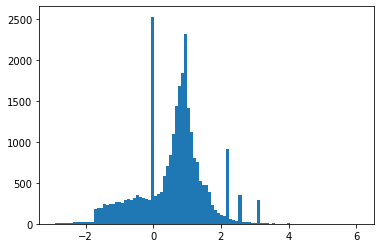

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [17]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

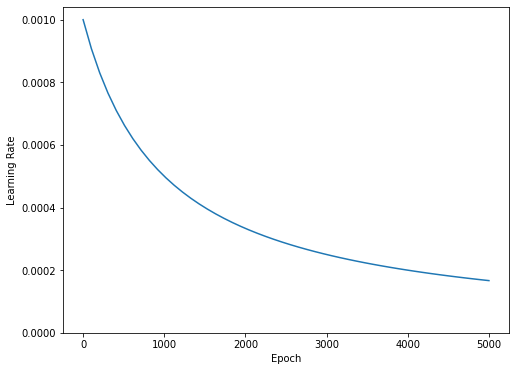

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [19]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [20]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model

Start by training a model:

In [21]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5142,  binary_crossentropy:0.7823,  loss:0.7823,  val_accuracy:0.5230,  val_binary_crossentropy:0.7322,  val_loss:0.7322,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 100, accuracy:0.5933,  binary_crossentropy:0.6284,  loss:0.6284,  val_accuracy:0.5730,  val_binary_crossentropy:0.6271,  val_loss:0.6271,  
..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

...

...

...

..

...

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

.
Epoch: 200, accuracy:0.6176,  binary_crossentropy:0.6135,  loss:0.6135,  val_accuracy:0.5950,  val_binary_crossentropy:0.6167,  val_loss:0.6167,  
.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

...

..

...

..

...

..

..

..

..

..

...

..

..

...

..

..

..

..

..

..

..

..

..

..

.
Epoch: 300, accuracy:0.6411,  binary_crossentropy:0.6011,  loss:0.6011,  val_accuracy:0.6230,  val_binary_crossentropy:0.6052,  val_loss:0.6052,  
.

...

..

..

..

..

..

..

..

...

...

..

..

...

..

..

...

...

...

...

...

...

..

...

...

...

...

...

...

...

..

...

...

...

...

...

..

...

..
Epoch: 400, accuracy:0.6542,  binary_crossentropy:0.5943,  loss:0.5943,  val_accuracy:0.6300,  val_binary_crossentropy:0.6003,  val_loss:0.6003,  
.

...

...

...

...

...

...

...

..

...

..

..

..

..

..

..

...

..

...

...

...

...

...

...

...

..

..

...

...

..

..

..

...

..

..

..

..

..

..

..

..


Epoch: 500, accuracy:0.6569,  binary_crossentropy:0.5903,  loss:0.5903,  val_accuracy:0.6470,  val_binary_crossentropy:0.5949,  val_loss:0.5949,  
..

...

...

...

..

..

...

...

..

...

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

...

..

...

...

..

..

..

..

..

..

..

..

..

..


Epoch: 600, accuracy:0.6631,  binary_crossentropy:0.5872,  loss:0.5872,  val_accuracy:0.6550,  val_binary_crossentropy:0.5927,  val_loss:0.5927,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..


Epoch: 700, accuracy:0.6673,  binary_crossentropy:0.5846,  loss:0.5846,  val_accuracy:0.6690,  val_binary_crossentropy:0.5905,  val_loss:0.5905,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

...

...


Epoch: 800, accuracy:0.6743,  binary_crossentropy:0.5824,  loss:0.5824,  val_accuracy:0.6710,  val_binary_crossentropy:0.5890,  val_loss:0.5890,  
..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.
Epoch: 900, accuracy:0.6739,  binary_crossentropy:0.5815,  loss:0.5815,  val_accuracy:0.6630,  val_binary_crossentropy:0.5888,  val_loss:0.5888,  
.

..

...

..

...

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

.
Epoch: 1000, accuracy:0.6748,  binary_crossentropy:0.5791,  loss:0.5791,  val_accuracy:0.6610,  val_binary_crossentropy:0.5881,  val_loss:0.5881,  
.

..

..

..

..

..

..

.

...

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..
Epoch: 1100, accuracy:0.6763,  binary_crossentropy:0.5774,  loss:0.5774,  val_accuracy:0.6710,  val_binary_crossentropy:0.5875,  val_loss:0.5875,  
.

..

..

..

..

...

..

..

..

...

..

..

..

...

..

..

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 1200, accuracy:0.6767,  binary_crossentropy:0.5763,  loss:0.5763,  val_accuracy:0.6630,  val_binary_crossentropy:0.5869,  val_loss:0.5869,  
..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

.
Epoch: 1300, accuracy:0.6833,  binary_crossentropy:0.5750,  loss:0.5750,  val_accuracy:0.6550,  val_binary_crossentropy:0.5878,  val_loss:0.5878,  
.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 1400, accuracy:0.6766,  binary_crossentropy:0.5737,  loss:0.5737,  val_accuracy:0.6710,  val_binary_crossentropy:0.5865,  val_loss:0.5865,  
..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..


Epoch: 1500, accuracy:0.6806,  binary_crossentropy:0.5727,  loss:0.5727,  val_accuracy:0.6630,  val_binary_crossentropy:0.5864,  val_loss:0.5864,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

...

...

...

...

...

...

...

..

..

..

..

..

..

..

..

..

..

..

..

...

...

...

...

...

.
Epoch: 1600, accuracy:0.6807,  binary_crossentropy:0.5717,  loss:0.5717,  val_accuracy:0.6720,  val_binary_crossentropy:0.5859,  val_loss:0.5859,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

.
Epoch: 1700, accuracy:0.6823,  binary_crossentropy:0.5707,  loss:0.5707,  val_accuracy:0.6570,  val_binary_crossentropy:0.5872,  val_loss:0.5872,  
.

..

..

..

..

.

Now check how the model did:

(0.5, 0.7)

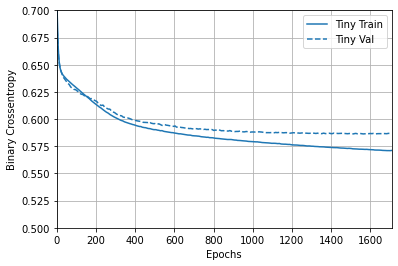

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [25]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5037,  binary_crossentropy:0.9699,  loss:0.9699,  val_accuracy:0.4950,  val_binary_crossentropy:0.7648,  val_loss:0.7648,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.


Epoch: 100, accuracy:0.6141,  binary_crossentropy:0.6173,  loss:0.6173,  val_accuracy:0.6000,  val_binary_crossentropy:0.6165,  val_loss:0.6165,  
..

...

...

...

...

...

...

..

..

..

..

...

...

..

...

...

..

..

..

...

...

...

...

...

..

..

..

...

..

..

...

..

..

..

..

...

...

..

...

..


Epoch: 200, accuracy:0.6532,  binary_crossentropy:0.5935,  loss:0.5935,  val_accuracy:0.6430,  val_binary_crossentropy:0.6023,  val_loss:0.6023,  
..

...

...

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

...

...

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..


Epoch: 300, accuracy:0.6762,  binary_crossentropy:0.5797,  loss:0.5797,  val_accuracy:0.6540,  val_binary_crossentropy:0.5987,  val_loss:0.5987,  
..

..

...

..

..

..

..

...

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

...

...

...

..

...

..

..

..

..

...

...

...


Epoch: 400, accuracy:0.6843,  binary_crossentropy:0.5725,  loss:0.5725,  val_accuracy:0.6570,  val_binary_crossentropy:0.6005,  val_loss:0.6005,  
...

..

..

..

...

...

..

...

..

..

..

..

..

..

..

..

..

...

...

..

..

..

..

...

...

...

...

..

...

..

...

...

### Medium model

Now try 3 hidden layers with 64 units each:

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [28]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4897,  binary_crossentropy:0.7502,  loss:0.7502,  val_accuracy:0.4590,  val_binary_crossentropy:0.7012,  val_loss:0.7012,  
...

...

...

...

...

...

...

...

..

...

...

...

..

...

...

...

..

..

..

...

...

...

...

...

...

...

..

...

...

...

..

..

..

..

..

..

..

..


Epoch: 100, accuracy:0.7040,  binary_crossentropy:0.5396,  loss:0.5396,  val_accuracy:0.6760,  val_binary_crossentropy:0.5956,  val_loss:0.5956,  
..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

...

..

..

.

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

.
Epoch: 200, accuracy:0.7784,  binary_crossentropy:0.4380,  loss:0.4380,  val_accuracy:0.6560,  val_binary_crossentropy:0.6714,  val_loss:0.6714,  
.

..

..

...

...

..

..

..

...

..

...

...

...

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [29]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [30]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.4901,  binary_crossentropy:0.8508,  loss:0.8508,  val_accuracy:0.5540,  val_binary_crossentropy:0.6800,  val_loss:0.6800,  
..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

.
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0025,  loss:0.0025,  val_accuracy:0.6480,  val_binary_crossentropy:1.7541,  val_loss:1.7541,  
.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..


Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0002,  loss:0.0002,  val_accuracy:0.6530,  val_binary_crossentropy:2.4090,  val_loss:2.4090,  
..

..

..

..

..

.

..

..

..

..

.

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

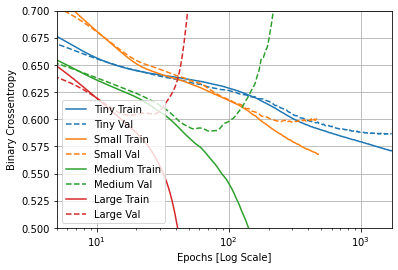

In [31]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [32]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpr1cbfjvl/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights-one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________



Epoch: 0, accuracy:0.5162,  binary_crossentropy:0.7512,  loss:2.2423,  val_accuracy:0.4830,  val_binary_crossentropy:0.6906,  val_loss:2.0808,  
..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..


Epoch: 100, accuracy:0.6586,  binary_crossentropy:0.5961,  loss:0.6196,  val_accuracy:0.6590,  val_binary_crossentropy:0.5953,  val_loss:0.6188,  
..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..


Epoch: 200, accuracy:0.6736,  binary_crossentropy:0.5817,  loss:0.6037,  val_accuracy:0.6610,  val_binary_crossentropy:0.5796,  val_loss:0.6015,  
..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 300, accuracy:0.6840,  binary_crossentropy:0.5771,  loss:0.6019,  val_accuracy:0.6770,  val_binary_crossentropy:0.5868,  val_loss:0.6124,  
..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..


Epoch: 400, accuracy:0.6926,  binary_crossentropy:0.5668,  loss:0.5924,  val_accuracy:0.6670,  val_binary_crossentropy:0.5748,  val_loss:0.6004,  
..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

.
Epoch: 500, accuracy:0.6991,  binary_crossentropy:0.5550,  loss:0.5824,  val_accuracy:0.6890,  val_binary_crossentropy:0.5743,  val_loss:0.6018,  
.

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..


Epoch: 600, accuracy:0.7073,  binary_crossentropy:0.5475,  loss:0.5758,  val_accuracy:0.6800,  val_binary_crossentropy:0.5734,  val_loss:0.6016,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

.
Epoch: 700, accuracy:0.7139,  binary_crossentropy:0.5381,  loss:0.5666,  val_accuracy:0.6770,  val_binary_crossentropy:0.5848,  val_loss:0.6132,  
.

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

.
Epoch: 800, accuracy:0.7169,  binary_crossentropy:0.5354,  loss:0.5645,  val_accuracy:0.6920,  val_binary_crossentropy:0.5835,  val_loss:0.6126,  
.

..

..

..

..

..

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.5, 0.7)

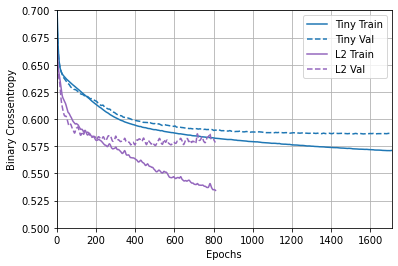

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [37]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [38]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              


Epoch: 0, accuracy:0.4944,  binary_crossentropy:0.8070,  loss:0.8070,  val_accuracy:0.5630,  val_binary_crossentropy:0.6919,  val_loss:0.6919,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 100, accuracy:0.6579,  binary_crossentropy:0.5956,  loss:0.5956,  val_accuracy:0.6780,  val_binary_crossentropy:0.5794,  val_loss:0.5794,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 200, accuracy:0.6878,  binary_crossentropy:0.5569,  loss:0.5569,  val_accuracy:0.6760,  val_binary_crossentropy:0.5896,  val_loss:0.5896,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

.
Epoch: 300, accuracy:0.7189,  binary_crossentropy:0.5084,  loss:0.5084,  val_accuracy:0.6960,  val_binary_crossentropy:0.6009,  val_loss:0.6009,  
.

..

.

..

..

..

..

..

..

..

..

(0.5, 0.7)

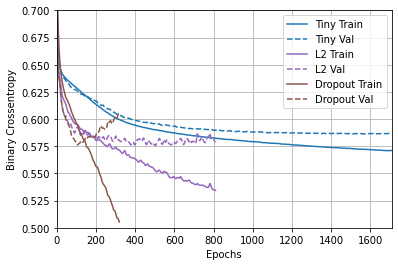

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [40]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              


Epoch: 0, accuracy:0.5052,  binary_crossentropy:0.8050,  loss:0.9634,  val_accuracy:0.4700,  val_binary_crossentropy:0.6965,  val_loss:0.8544,  
..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..


Epoch: 100, accuracy:0.6432,  binary_crossentropy:0.6061,  loss:0.6349,  val_accuracy:0.6440,  val_binary_crossentropy:0.5868,  val_loss:0.6154,  
..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

.
Epoch: 200, accuracy:0.6633,  binary_crossentropy:0.5916,  loss:0.6159,  val_accuracy:0.6420,  val_binary_crossentropy:0.5788,  val_loss:0.6031,  
.

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

.
Epoch: 300, accuracy:0.6685,  binary_crossentropy:0.5828,  loss:0.6107,  val_accuracy:0.6900,  val_binary_crossentropy:0.5632,  val_loss:0.5911,  
.

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..


Epoch: 400, accuracy:0.6719,  binary_crossentropy:0.5808,  loss:0.6102,  val_accuracy:0.6880,  val_binary_crossentropy:0.5620,  val_loss:0.5914,  
..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

.
Epoch: 500, accuracy:0.6776,  binary_crossentropy:0.5739,  loss:0.6050,  val_accuracy:0.6880,  val_binary_crossentropy:0.5539,  val_loss:0.5851,  
.

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

.
Epoch: 600, accuracy:0.6856,  binary_crossentropy:0.5669,  loss:0.6006,  val_accuracy:0.6960,  val_binary_crossentropy:0.5493,  val_loss:0.5830,  
.

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.
Epoch: 700, accuracy:0.6833,  binary_crossentropy:0.5648,  loss:0.5996,  val_accuracy:0.6980,  val_binary_crossentropy:0.5430,  val_loss:0.5778,  
.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

.
Epoch: 800, accuracy:0.6943,  binary_crossentropy:0.5594,  loss:0.5955,  val_accuracy:0.6930,  val_binary_crossentropy:0.5412,  val_loss:0.5772,  
.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..


Epoch: 900, accuracy:0.6966,  binary_crossentropy:0.5558,  loss:0.5932,  val_accuracy:0.7060,  val_binary_crossentropy:0.5419,  val_loss:0.5793,  
..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

.

..

..

..

..

..

..

..

..

..

..

..

..

..

..

..

.

..

.

(0.5, 0.7)

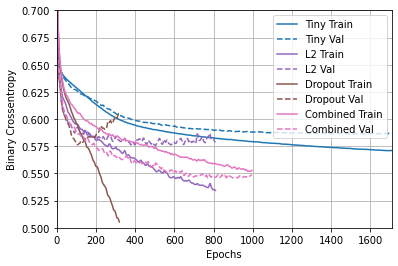

In [41]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.